In [1]:
from matplotlib import pyplot
from functools import partial
import numpy
import pandas
import ROOT

Welcome to JupyROOT 6.27/01


In [2]:
### UTILS
def round_to_nearest_5(n) -> int:
    r = round(n, -1)
    return r if r > n  else r + 5

def get_y_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    y_1 = graph1.GetY()
    n_2 = graph2.GetN()
    y_2 = graph2.GetY()

    ymin_1 = ROOT.TMath.MinElement(n_1, y_1)
    ymax_1 = ROOT.TMath.MaxElement(n_1, y_1)

    ymin_2 = ROOT.TMath.MinElement(n_2, y_2)
    ymax_2 = ROOT.TMath.MaxElement(n_2, y_2)
    
    return min(ymin_1, ymin_2), max(ymax_1, ymax_2)

def get_x_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    x_1 = graph1.GetX()
    n_2 = graph2.GetN()
    x_2 = graph2.GetX()

    xmin_1 = ROOT.TMath.MinElement(n_1, x_1)
    xmax_1 = ROOT.TMath.MaxElement(n_1, x_1)

    xmin_2 = ROOT.TMath.MinElement(n_2, x_2)
    xmax_2 = ROOT.TMath.MaxElement(n_2, x_2)
    
    return min(xmin_1, xmin_2), max(xmax_1, xmax_2)

def create_mpl_tcolors() -> dict[str, ROOT.TColor]:
    import matplotlib.colors as mcolors
    return {
        name: ROOT.TColor.GetColor(color)
        for name, color in mcolors.TABLEAU_COLORS.items()
        
    }

PYPLOT_TCOLORS = create_mpl_tcolors()

In [3]:
df = pandas.read_csv("data.csv")
df

,scheduler,ncores,cold,hot
0,dask,32,5248,5184
1,dask,64,2624,2592
2,dask,128,1312,1296
3,dask,256,683,661
4,dask,512,346,338
5,dask,1024,195,189
6,dask,2048,104,96
7,spark,32,5076,5040
8,spark,64,2538,2520
9,spark,128,1269,1260


In [4]:
size_1file_bytes = 2244449133
size_1file_mib = size_1file_bytes / 1024 / 1024
nfiles = 4000
size_b = size_1file_bytes * nfiles
size_kib = size_b / 1024
size_mib = size_kib / 1024
size_GB = size_mib / 1024
print(size_GB)

8361.224580556154


In [5]:
size_1file_bytes = 2244449133
size_1file_mb = size_1file_bytes / 1e6
nfiles = 4000
size_b = size_1file_bytes * nfiles
size_gb = size_b / 1e9
print(size_gb)

8977.796532


In [6]:
dfs = {}

def amdahls(time_1, values):
    ncores, time_n = values
    return (ncores /(ncores - 1)) * ((time_1 - time_n)/(time_1))

for label, group in df.groupby("scheduler"):
    dfs[label] = group
    dfs[label]["cold_minutes"]  = dfs[label]["cold"] / 60
    dfs[label]["hot_minutes"]  = dfs[label]["hot"] / 60
    dfs[label]["throughput_cold"] = size_gb / dfs[label]["cold"]
    dfs[label]["throughput_hot"] = size_gb / dfs[label]["hot"]
    first_cold = dfs[label]["throughput_cold"].iloc[0]
    first_hot = dfs[label]["throughput_hot"].iloc[0]
    dfs[label]["speedup_cold"] = dfs[label]["throughput_cold"] / first_cold
    dfs[label]["speedup_hot"] = dfs[label]["throughput_hot"] / first_hot
    first_cold = dfs[label]["cold"].iloc[0]
    first_hot = dfs[label]["hot"].iloc[0]
    dfs[label]["amdahl_cold"] = dfs[label][["ncores","cold"]].apply(partial(amdahls, first_cold), 1)
    dfs[label]["amdahl_hot"] = dfs[label][["ncores","hot"]].apply(partial(amdahls, first_hot), 1)

In [7]:
dfs["spark"]

,scheduler,ncores,cold,hot,cold_minutes,hot_minutes,throughput_cold,throughput_hot,speedup_cold,speedup_hot,amdahl_cold,amdahl_hot
7,spark,32,5076,5040,84.600000,84.000000,1.768675,1.781309,1.000000,1.000000,0.000000,0.000000
8,spark,64,2538,2520,42.300000,42.000000,3.537351,3.562618,2.000000,2.000000,0.507937,0.507937
9,spark,128,1269,1260,21.150000,21.000000,7.074702,7.125235,4.000000,4.000000,0.755906,0.755906
10,spark,256,673,660,11.216667,11.000000,13.339965,13.602722,7.542348,7.636364,0.870817,0.872456
11,spark,512,352,345,5.866667,5.750000,25.505104,26.022599,14.420455,14.608696,0.932475,0.933371
12,spark,1024,193,182,3.216667,3.033333,46.517080,49.328552,26.300518,27.692308,0.962918,0.964831
13,spark,2048,103,88,1.716667,1.466667,87.163073,102.020415,49.281553,57.272727,0.980187,0.983020


In [8]:
dfs["dask"]

,scheduler,ncores,cold,hot,cold_minutes,hot_minutes,throughput_cold,throughput_hot,speedup_cold,speedup_hot,amdahl_cold,amdahl_hot
0,dask,32,5248,5184,87.466667,86.400000,1.710708,1.731828,1.000000,1.000000,0.000000,0.000000
1,dask,64,2624,2592,43.733333,43.200000,3.421416,3.463656,2.000000,2.000000,0.507937,0.507937
2,dask,128,1312,1296,21.866667,21.600000,6.842833,6.927312,4.000000,4.000000,0.755906,0.755906
3,dask,256,683,661,11.383333,11.016667,13.144651,13.582143,7.683748,7.842663,0.873266,0.875914
4,dask,512,346,338,5.766667,5.633333,25.947389,26.561528,15.167630,15.337278,0.935898,0.936629
5,dask,1024,195,189,3.250000,3.150000,46.039982,47.501569,26.912821,27.428571,0.963784,0.964484
6,dask,2048,104,96,1.733333,1.600000,86.324967,93.518714,50.461538,54.000000,0.980662,0.981961


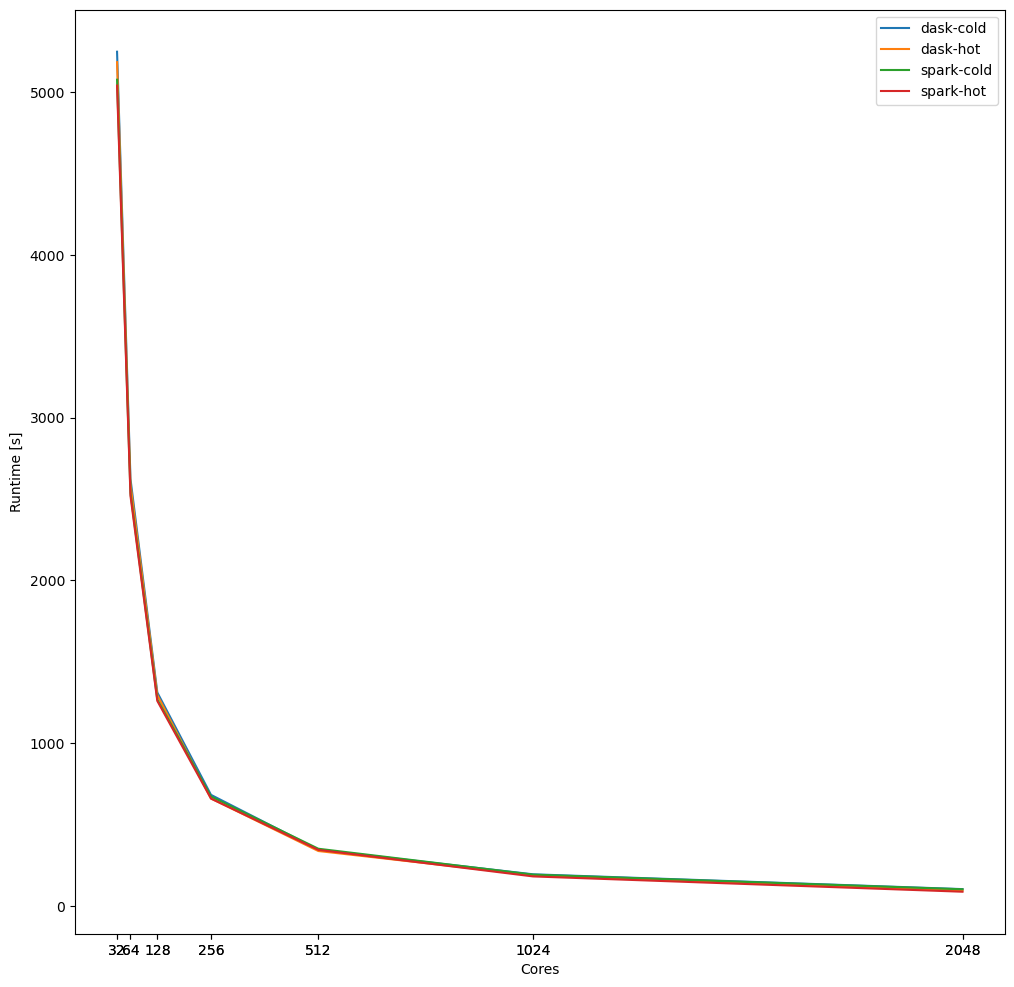

In [9]:
schedulers = df.groupby("scheduler")
# Plot
fig, ax = pyplot.subplots(figsize=(12,12))
pyplot.xticks(df.ncores)
pyplot.xlabel("Cores")
pyplot.ylabel("Runtime [s]")
for name, scheduler in schedulers:
    ax.plot(scheduler.ncores, scheduler.cold, label=name+"-cold")
    ax.plot(scheduler.ncores, scheduler.hot, label=name+"-hot")
ax.legend()

# TGraph

Info in <TCanvas::Print>: png file throughput_comparison_hot_and_cold.png has been created


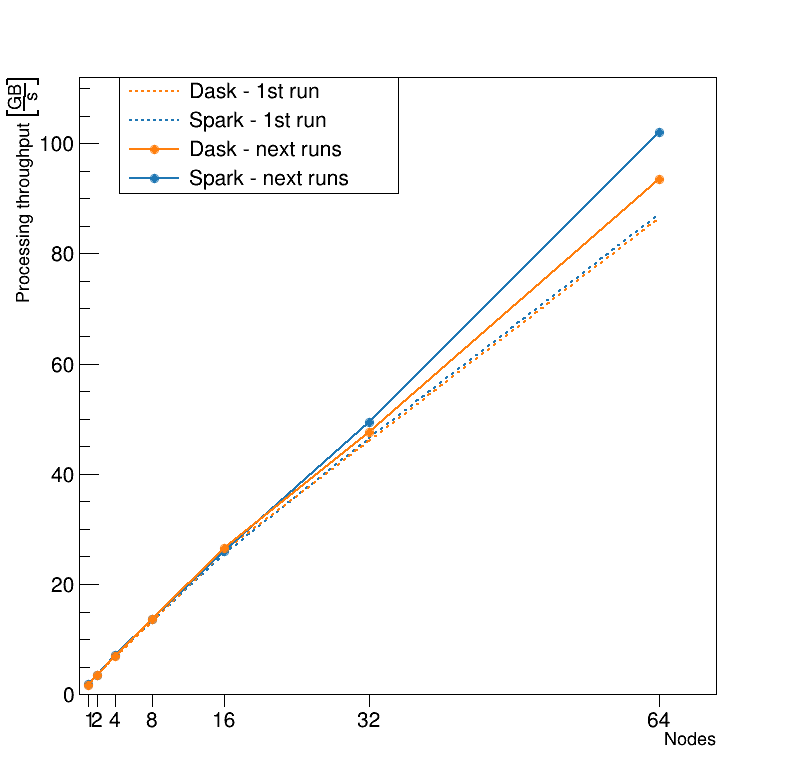

In [10]:
sparkgraph_cold = ROOT.TGraph(
    len(dfs["spark"]["ncores"]),
    numpy.array(dfs["spark"]["ncores"], dtype=float),
    numpy.array(dfs["spark"]["throughput_cold"], dtype=float)
)
daskgraph_cold = ROOT.TGraph(
    len(dfs["dask"]["ncores"]),
    numpy.array(dfs["dask"]["ncores"], dtype=float),
    numpy.array(dfs["dask"]["throughput_cold"], dtype=float)
)

sparkgraph_hot = ROOT.TGraph(
    len(dfs["spark"]["ncores"]),
    numpy.array(dfs["spark"]["ncores"], dtype=float),
    numpy.array(dfs["spark"]["throughput_hot"], dtype=float)
)
daskgraph_hot = ROOT.TGraph(
    len(dfs["dask"]["ncores"]),
    numpy.array(dfs["dask"]["ncores"], dtype=float),
    numpy.array(dfs["dask"]["throughput_hot"], dtype=float)
)

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

ymin = sparkgraph_hot.GetHistogram().GetMinimum()
ymax = sparkgraph_hot.GetHistogram().GetMaximum()

sparkgraph_cold.SetTitle("")

sparkgraph_cold.GetXaxis().SetTitle("Nodes")
sparkgraph_cold.GetXaxis().SetTitleSize(0.025)
sparkgraph_cold.GetXaxis().SetTitleOffset(1.4)
sparkgraph_cold.GetXaxis().SetLabelSize(0)
sparkgraph_cold.GetXaxis().SetTickLength(0)

sparkgraph_cold.GetYaxis().SetTitle("Processing throughput #left[#frac{GB}{s}#right]")
sparkgraph_cold.GetYaxis().SetTitleSize(0.025)
sparkgraph_cold.GetYaxis().SetTitleOffset(1.8)
sparkgraph_cold.GetYaxis().SetRangeUser(0, sparkgraph_hot.GetHistogram().GetMaximum())
sparkgraph_cold.GetYaxis().SetLabelSize(0.03)
#sparkgraph.GetYaxis().SetTickLength(0)


sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
#sparkgraph_cold.SetMarkerSize(1)
#sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetLineStyle(ROOT.kDashed)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(2)
sparkgraph_cold.Draw("AL")



dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_cold.GetPointX(i)
    y = sparkgraph_cold.GetPointY(i)

    xt = ROOT.TLatex(x, -6, str(int(x/32)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_cold.GetYaxis().SetLabelSize(0)
#daskgraph_cold.SetMarkerSize(1)
#daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kDashed)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(2)

daskgraph_cold.Draw("SAME L")


sparkgraph_hot.GetYaxis().SetLabelSize(0)
sparkgraph_hot.SetMarkerSize(1)
sparkgraph_hot.SetMarkerStyle(20)
sparkgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_hot.SetLineStyle(ROOT.kSolid)
sparkgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_hot.SetLineWidth(2)

sparkgraph_hot.Draw("SAME PL")


daskgraph_hot.GetYaxis().SetLabelSize(0)
daskgraph_hot.SetMarkerSize(1)
daskgraph_hot.SetMarkerStyle(20)
daskgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_hot.SetLineStyle(ROOT.kSolid)
daskgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_hot.SetLineWidth(2)

daskgraph_hot.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.75,0.5,0.9)
legend.AddEntry(daskgraph_cold, "Dask - 1st run")
legend.AddEntry(sparkgraph_cold, "Spark - 1st run")
legend.AddEntry(daskgraph_hot, "Dask - next runs")
legend.AddEntry(sparkgraph_hot, "Spark - next runs")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.03)

c.Draw()
c.SaveAs("throughput_comparison_hot_and_cold.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file speedup_comparison_hot_and_cold.png has been created


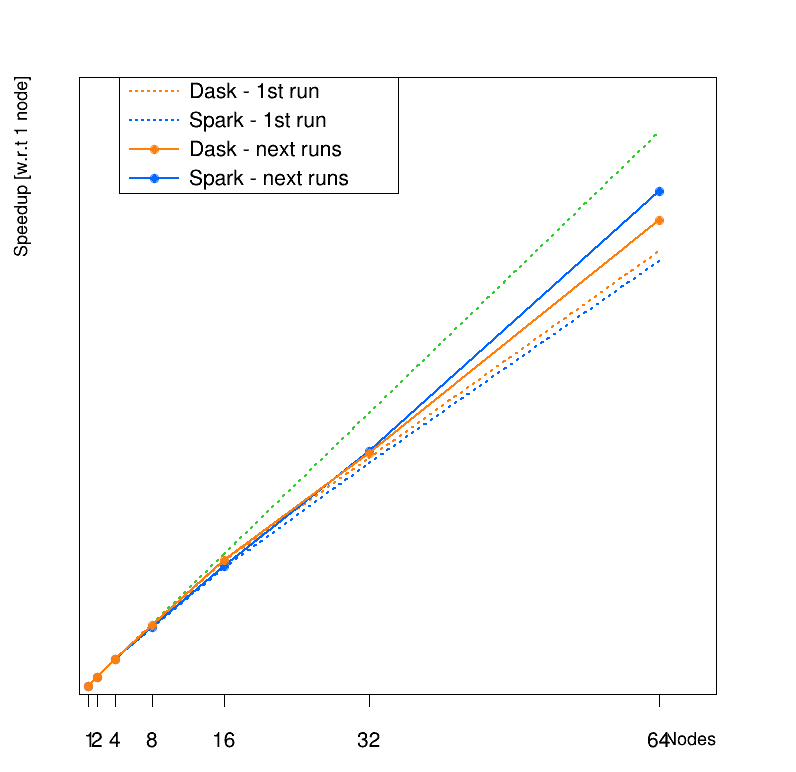

In [11]:
sparkgraph_cold = ROOT.TGraph(len(dfs["spark"]["ncores"]), numpy.array(dfs["spark"]["ncores"], dtype=float), numpy.array(dfs["spark"]["speedup_cold"], dtype=float))
daskgraph_cold = ROOT.TGraph(len(dfs["dask"]["ncores"]), numpy.array(dfs["dask"]["ncores"], dtype=float), numpy.array(dfs["dask"]["speedup_cold"], dtype=float))

sparkgraph_hot = ROOT.TGraph(len(dfs["spark"]["ncores"]), numpy.array(dfs["spark"]["ncores"], dtype=float), numpy.array(dfs["spark"]["speedup_hot"], dtype=float))
daskgraph_hot = ROOT.TGraph(len(dfs["dask"]["ncores"]), numpy.array(dfs["dask"]["ncores"], dtype=float), numpy.array(dfs["dask"]["speedup_hot"], dtype=float))

idealspeedupgraph = ROOT.TGraph(len(dfs["dask"]["ncores"]), numpy.array(dfs["dask"]["ncores"], dtype=float), numpy.array(dfs["dask"]["ncores"]/32, dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 node]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0)
idealspeedupgraph.GetYaxis().SetTickLength(0)

idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kGreen-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")




dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_cold.GetPointX(i)
    y = sparkgraph_cold.GetPointY(i)

    xt = ROOT.TLatex(x, -6, str(int(x/32)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


    
sparkgraph_cold.SetTitle("")

sparkgraph_cold.GetXaxis().SetTitle("Nodes")
sparkgraph_cold.GetXaxis().SetTitleSize(0.025)
sparkgraph_cold.GetXaxis().SetTitleOffset(1.4)
sparkgraph_cold.GetXaxis().SetLabelSize(0)
sparkgraph_cold.GetXaxis().SetTickLength(0)

sparkgraph_cold.GetYaxis().SetTitle("Processing throughput [GB/s]")
sparkgraph_cold.GetYaxis().SetTitleSize(0.025)
sparkgraph_cold.GetYaxis().SetTitleOffset(1.8)
sparkgraph_cold.GetYaxis().SetRangeUser(0, sparkgraph_hot.GetHistogram().GetMaximum())
sparkgraph_cold.GetYaxis().SetLabelSize(0.03)


sparkgraph_cold.SetMarkerColor(ROOT.kAzure-3)
#sparkgraph_cold.SetMarkerSize(1)
#sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetLineStyle(ROOT.kDashed)
sparkgraph_cold.SetLineColorAlpha(ROOT.kAzure-3,1)
sparkgraph_cold.SetLineWidth(2)
sparkgraph_cold.Draw("SAME L")
    
daskgraph_cold.GetYaxis().SetLabelSize(0)
#daskgraph_cold.SetMarkerSize(1)
#daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kDashed)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(2)

daskgraph_cold.Draw("SAME L")


sparkgraph_hot.GetYaxis().SetLabelSize(0)
sparkgraph_hot.SetMarkerSize(1)
sparkgraph_hot.SetMarkerStyle(20)
sparkgraph_hot.SetMarkerColor(ROOT.kAzure-3)
sparkgraph_hot.SetLineStyle(ROOT.kSolid)
sparkgraph_hot.SetLineColorAlpha(ROOT.kAzure-3,1)
sparkgraph_hot.SetLineWidth(2)

sparkgraph_hot.Draw("SAME PL")


daskgraph_hot.GetYaxis().SetLabelSize(0)
daskgraph_hot.SetMarkerSize(1)
daskgraph_hot.SetMarkerStyle(20)
daskgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_hot.SetLineStyle(ROOT.kSolid)
daskgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_hot.SetLineWidth(2)

daskgraph_hot.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.75,0.5,0.9)
legend.AddEntry(daskgraph_cold, "Dask - 1st run")
legend.AddEntry(sparkgraph_cold, "Spark - 1st run")
legend.AddEntry(daskgraph_hot, "Dask - next runs")
legend.AddEntry(sparkgraph_hot, "Spark - next runs")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.03)

c.Draw()
c.SaveAs("speedup_comparison_hot_and_cold.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file throughput_cold.png has been created


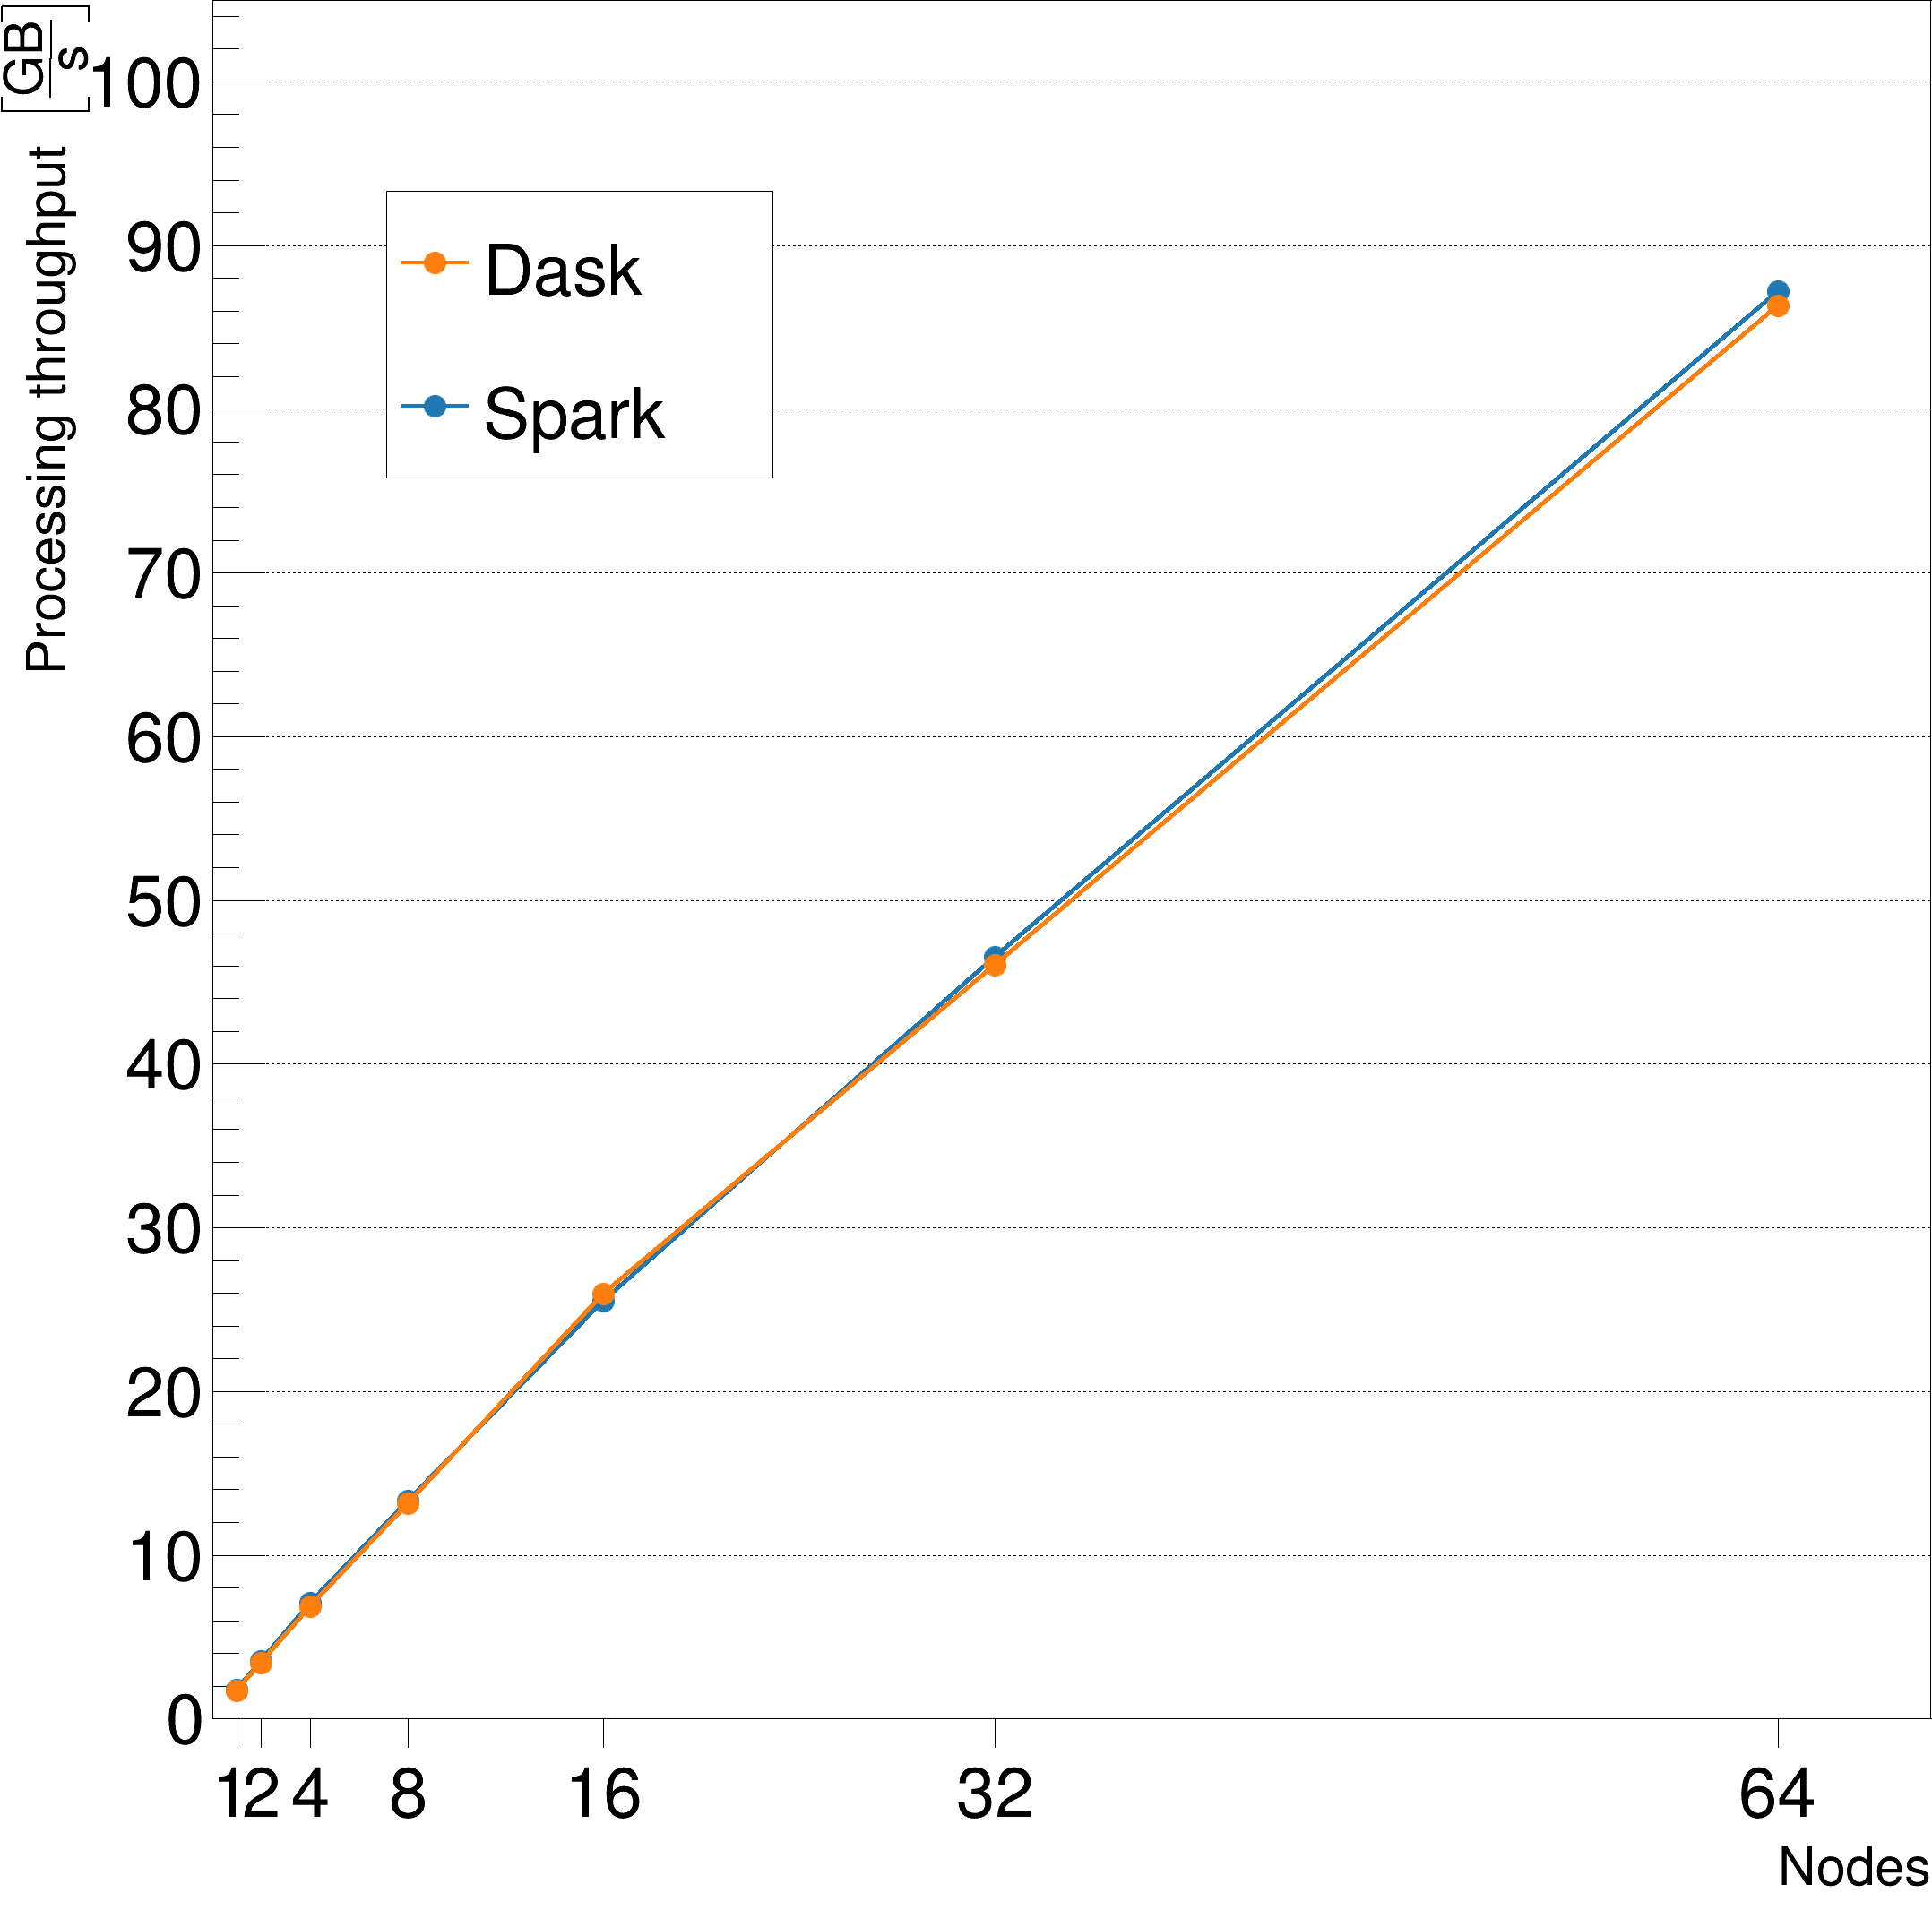

In [12]:
sparkgraph_cold = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                              numpy.array(dfs["spark"]["ncores"], dtype=float),
                              numpy.array(dfs["spark"]["throughput_cold"], dtype=float))
daskgraph_cold = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                             numpy.array(dfs["dask"]["ncores"], dtype=float),
                             numpy.array(dfs["dask"]["throughput_cold"], dtype=float))

sparkgraph_hot = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                             numpy.array(dfs["spark"]["ncores"], dtype=float),
                             numpy.array(dfs["spark"]["throughput_hot"], dtype=float))
daskgraph_hot = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                            numpy.array(dfs["dask"]["ncores"], dtype=float),
                            numpy.array(dfs["dask"]["throughput_hot"], dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin = ROOT.TMath.MinElement(sparkgraph_cold.GetN(), sparkgraph_cold.GetY())
ymax = ROOT.TMath.MaxElement(sparkgraph_cold.GetN(), sparkgraph_cold.GetY())

sparkgraph_cold.SetTitle("")

sparkgraph_cold.GetXaxis().SetTitle("Nodes")
sparkgraph_cold.GetXaxis().SetTitleSize(0.03)
sparkgraph_cold.GetXaxis().SetTitleOffset(1.6)
sparkgraph_cold.GetXaxis().SetLabelSize(0)
sparkgraph_cold.GetXaxis().SetTickLength(0)

sparkgraph_cold.GetYaxis().SetTitle("Processing throughput #left[#frac{GB}{s}#right]")
sparkgraph_cold.GetYaxis().SetTitleSize(0.03)
sparkgraph_cold.GetYaxis().SetTitleOffset(1.8)
sparkgraph_cold.GetYaxis().SetRangeUser(0, 105)
sparkgraph_cold.GetYaxis().SetLabelSize(0.04)
sparkgraph_cold.GetYaxis().SetNdivisions(515)
#sparkgraph.GetYaxis().SetTickLength(0)


sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)
sparkgraph_cold.Draw("ALP")


dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_cold.GetPointX(i)
    y = sparkgraph_cold.GetPointY(i)

    xt = ROOT.TLatex(x, -6, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_cold.GetYaxis().SetLabelSize(0)
daskgraph_cold.SetMarkerSize(3)
daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kSolid)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(4)

daskgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_cold, "Dask")
legend.AddEntry(sparkgraph_cold, "Spark")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(2)

c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("throughput_cold.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file throughput_hot.png has been created


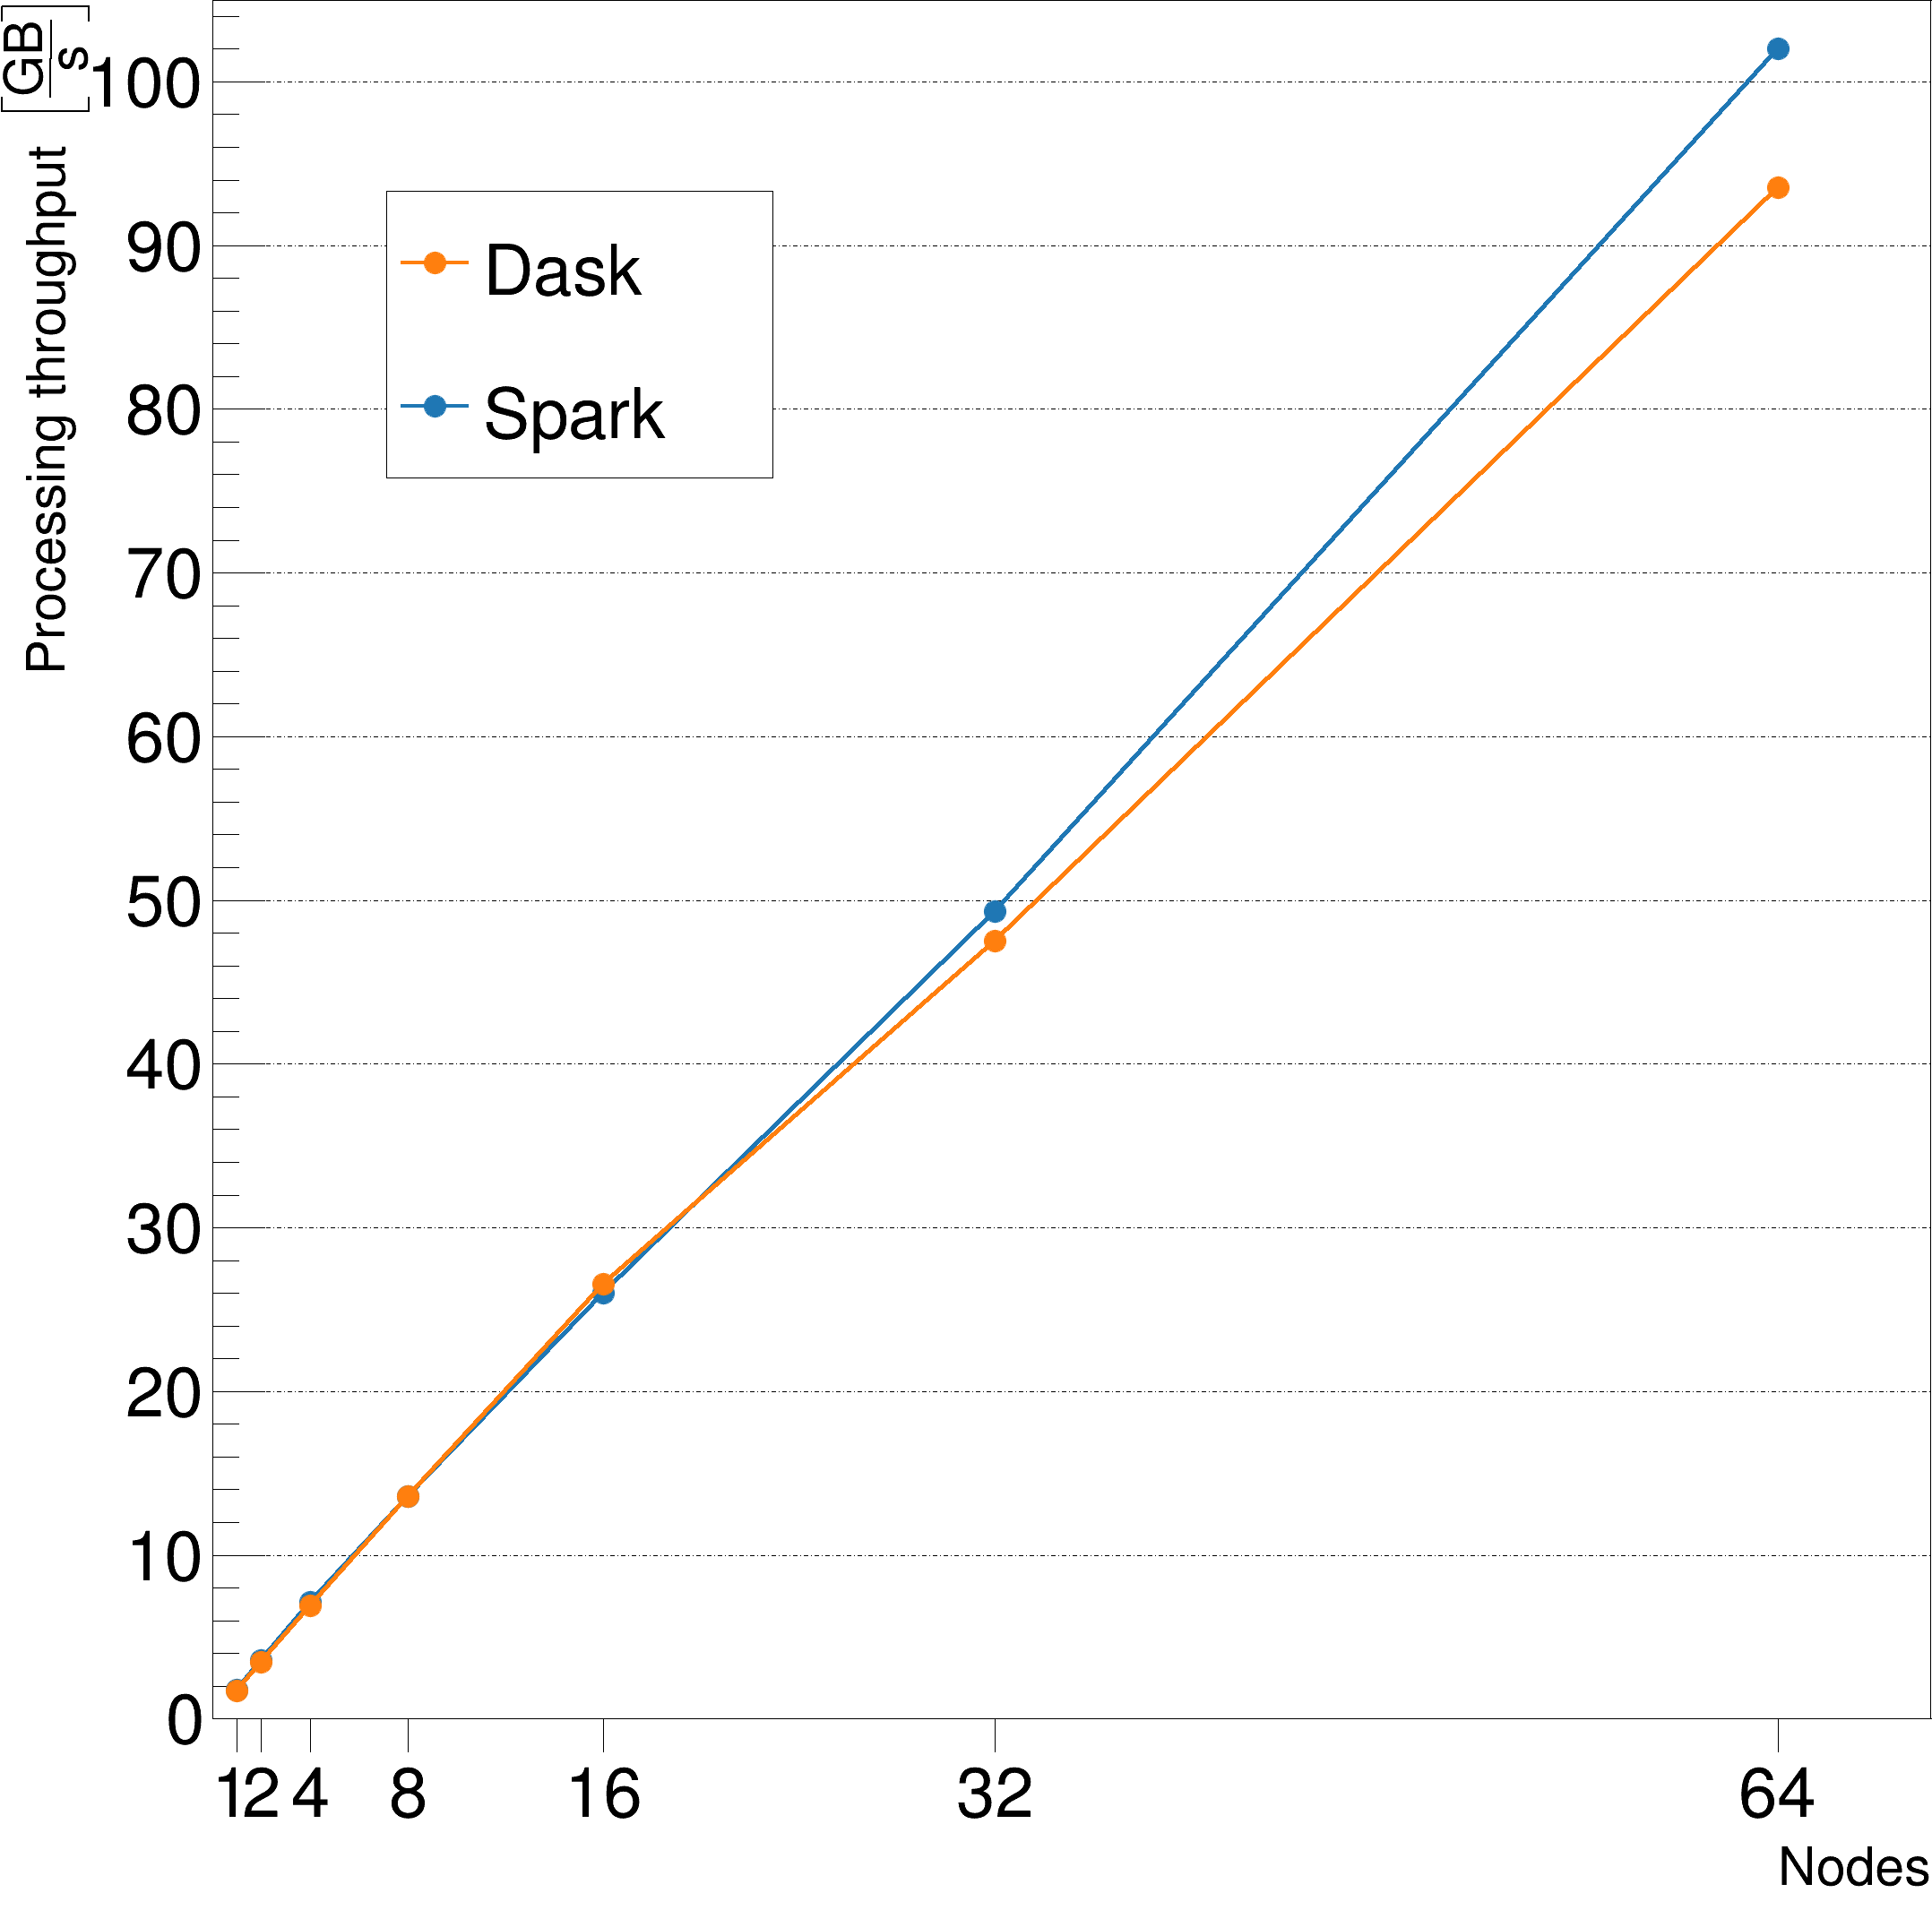

In [13]:
sparkgraph_hot = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                             numpy.array(dfs["spark"]["ncores"], dtype=float),
                             numpy.array(dfs["spark"]["throughput_hot"], dtype=float))
daskgraph_hot = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                            numpy.array(dfs["dask"]["ncores"], dtype=float),
                            numpy.array(dfs["dask"]["throughput_hot"], dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin = ROOT.TMath.MinElement(sparkgraph_hot.GetN(), sparkgraph_hot.GetY())
ymax = ROOT.TMath.MaxElement(sparkgraph_hot.GetN(), sparkgraph_hot.GetY())

sparkgraph_hot.SetTitle("")

sparkgraph_hot.GetXaxis().SetTitle("Nodes")
sparkgraph_hot.GetXaxis().SetTitleSize(0.03)
sparkgraph_hot.GetXaxis().SetTitleOffset(1.6)
sparkgraph_hot.GetXaxis().SetLabelSize(0)
sparkgraph_hot.GetXaxis().SetTickLength(0)

sparkgraph_hot.GetYaxis().SetTitle("Processing throughput #left[#frac{GB}{s}#right]")
sparkgraph_hot.GetYaxis().SetTitleSize(0.03)
sparkgraph_hot.GetYaxis().SetTitleOffset(1.8)
sparkgraph_hot.GetYaxis().SetRangeUser(0, round_to_nearest_5(ymax))
sparkgraph_hot.GetYaxis().SetLabelSize(0.04)
sparkgraph_hot.GetYaxis().SetNdivisions(515)
#sparkgraph.GetYaxis().SetTickLength(0)


sparkgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_hot.SetMarkerSize(3)
sparkgraph_hot.SetMarkerStyle(20)
sparkgraph_hot.SetLineStyle(ROOT.kSolid)
sparkgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_hot.SetLineWidth(4)
sparkgraph_hot.Draw("ALP")


dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_hot.GetPointX(i)
    y = sparkgraph_hot.GetPointY(i)

    xt = ROOT.TLatex(x, -6, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_hot.GetYaxis().SetLabelSize(0)
daskgraph_hot.SetMarkerSize(3)
daskgraph_hot.SetMarkerStyle(20)
daskgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_hot.SetLineStyle(ROOT.kSolid)
daskgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_hot.SetLineWidth(4)

daskgraph_hot.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_hot, "Dask")
legend.AddEntry(sparkgraph_hot, "Spark")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()


c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("throughput_hot.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file throughput_hot_coreslabel.png has been created


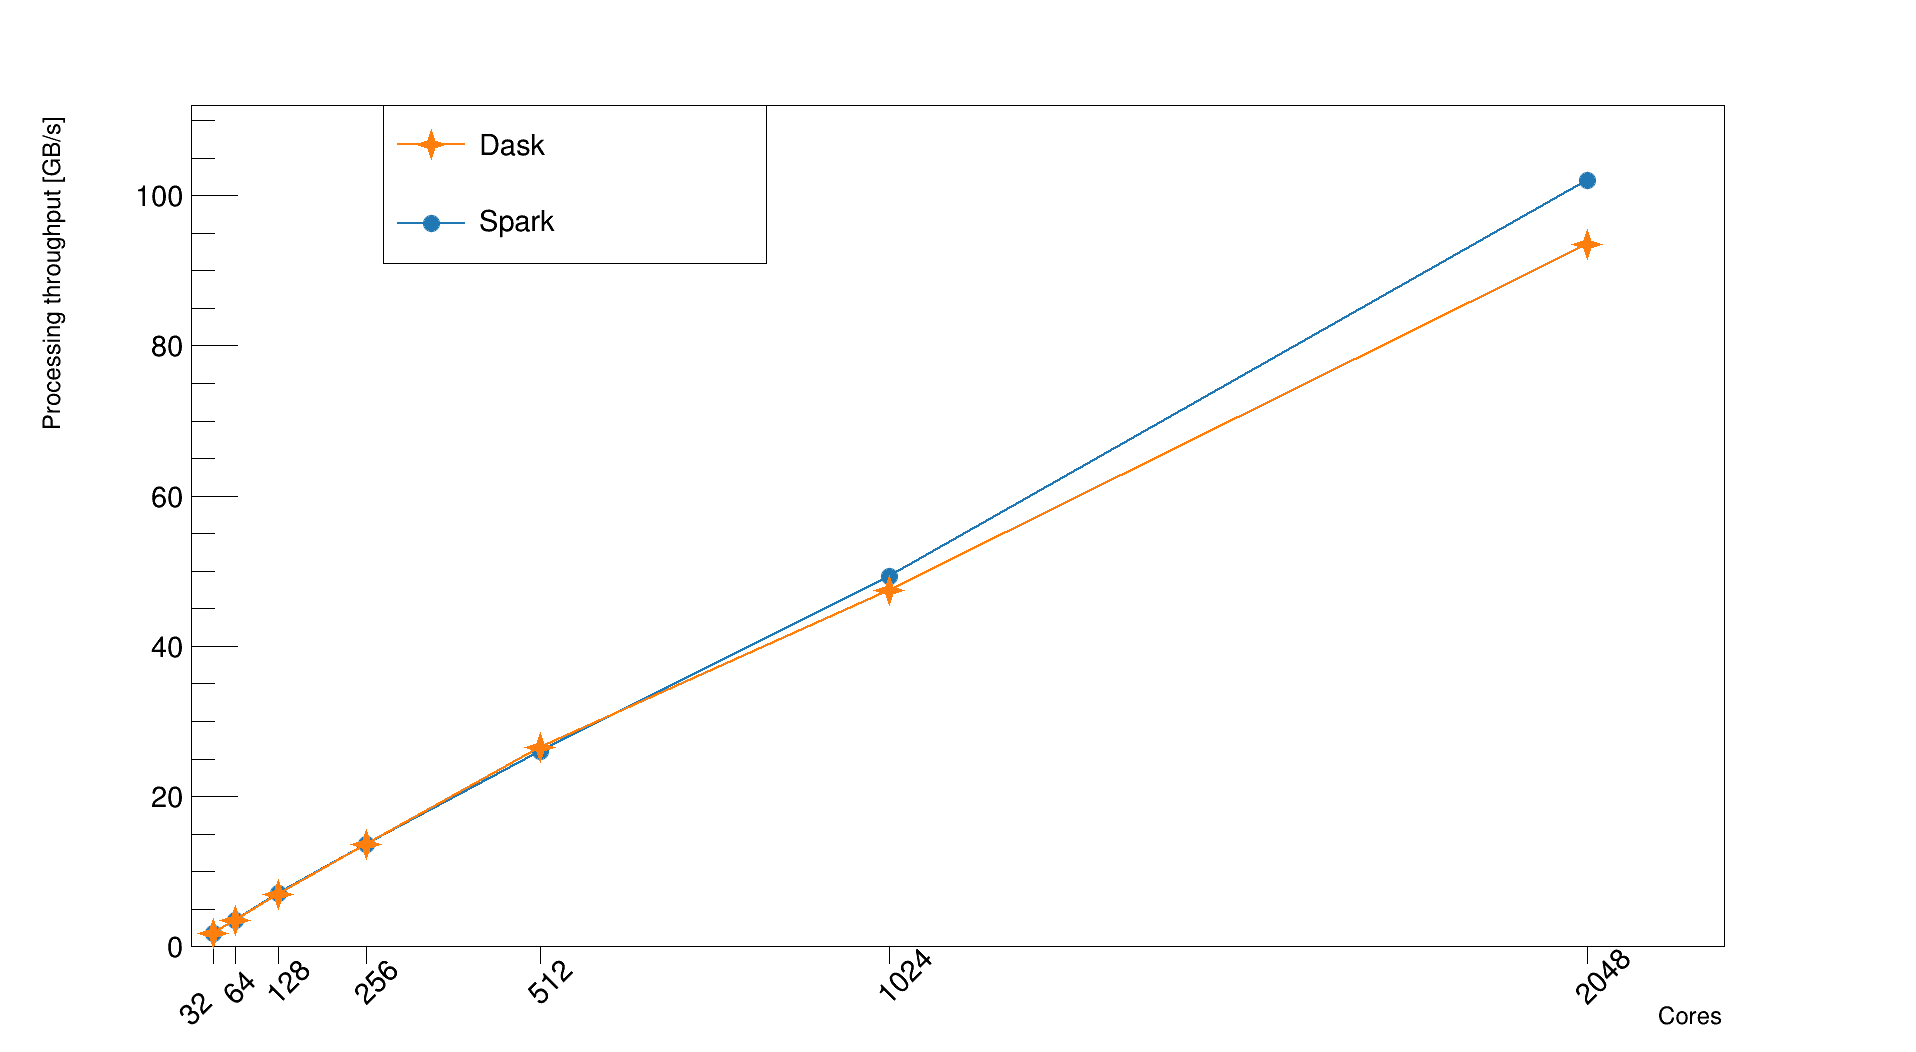

In [14]:
sparkgraph_hot = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                             numpy.array(dfs["spark"]["ncores"], dtype=float),
                             numpy.array(dfs["spark"]["throughput_hot"], dtype=float))
daskgraph_hot = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                            numpy.array(dfs["dask"]["ncores"], dtype=float),
                            numpy.array(dfs["dask"]["throughput_hot"], dtype=float))

width = 1920
height = 1080
c = ROOT.TCanvas("c", "", width, height)

ymin = sparkgraph_hot.GetHistogram().GetMinimum()
ymax = sparkgraph_hot.GetHistogram().GetMaximum()

sparkgraph_hot.SetTitle("")

sparkgraph_hot.GetXaxis().SetTitle("Cores")
sparkgraph_hot.GetXaxis().SetTitleSize(0.025)
sparkgraph_hot.GetXaxis().SetTitleOffset(1.6)
sparkgraph_hot.GetXaxis().SetLabelSize(0)
sparkgraph_hot.GetXaxis().SetTickLength(0)

sparkgraph_hot.GetYaxis().SetTitle("Processing throughput [GB/s]")
sparkgraph_hot.GetYaxis().SetTitleSize(0.025)
sparkgraph_hot.GetYaxis().SetTitleOffset(1.8)
sparkgraph_hot.GetYaxis().SetRangeUser(0, ymax)
sparkgraph_hot.GetYaxis().SetLabelSize(0.03)

sparkgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_hot.SetMarkerSize(2)
sparkgraph_hot.SetMarkerStyle(20)
sparkgraph_hot.SetLineStyle(ROOT.kSolid)
sparkgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_hot.SetLineWidth(2)
sparkgraph_hot.Draw("ALP")


dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_hot.GetPointX(i)
    y = sparkgraph_hot.GetPointY(i)

    xt = ROOT.TLatex(x, -8, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)

    xt.SetTextAngle(45)
    
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(11)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_hot.GetYaxis().SetLabelSize(0)
daskgraph_hot.SetMarkerSize(4)
daskgraph_hot.SetMarkerStyle(43)
daskgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_hot.SetLineStyle(ROOT.kSolid)
daskgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_hot.SetLineWidth(2)

daskgraph_hot.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_hot, "Dask")
legend.AddEntry(sparkgraph_hot, "Spark")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.03)

c.Draw()
c.SaveAs("throughput_hot_coreslabel.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file speedup_cold.png has been created


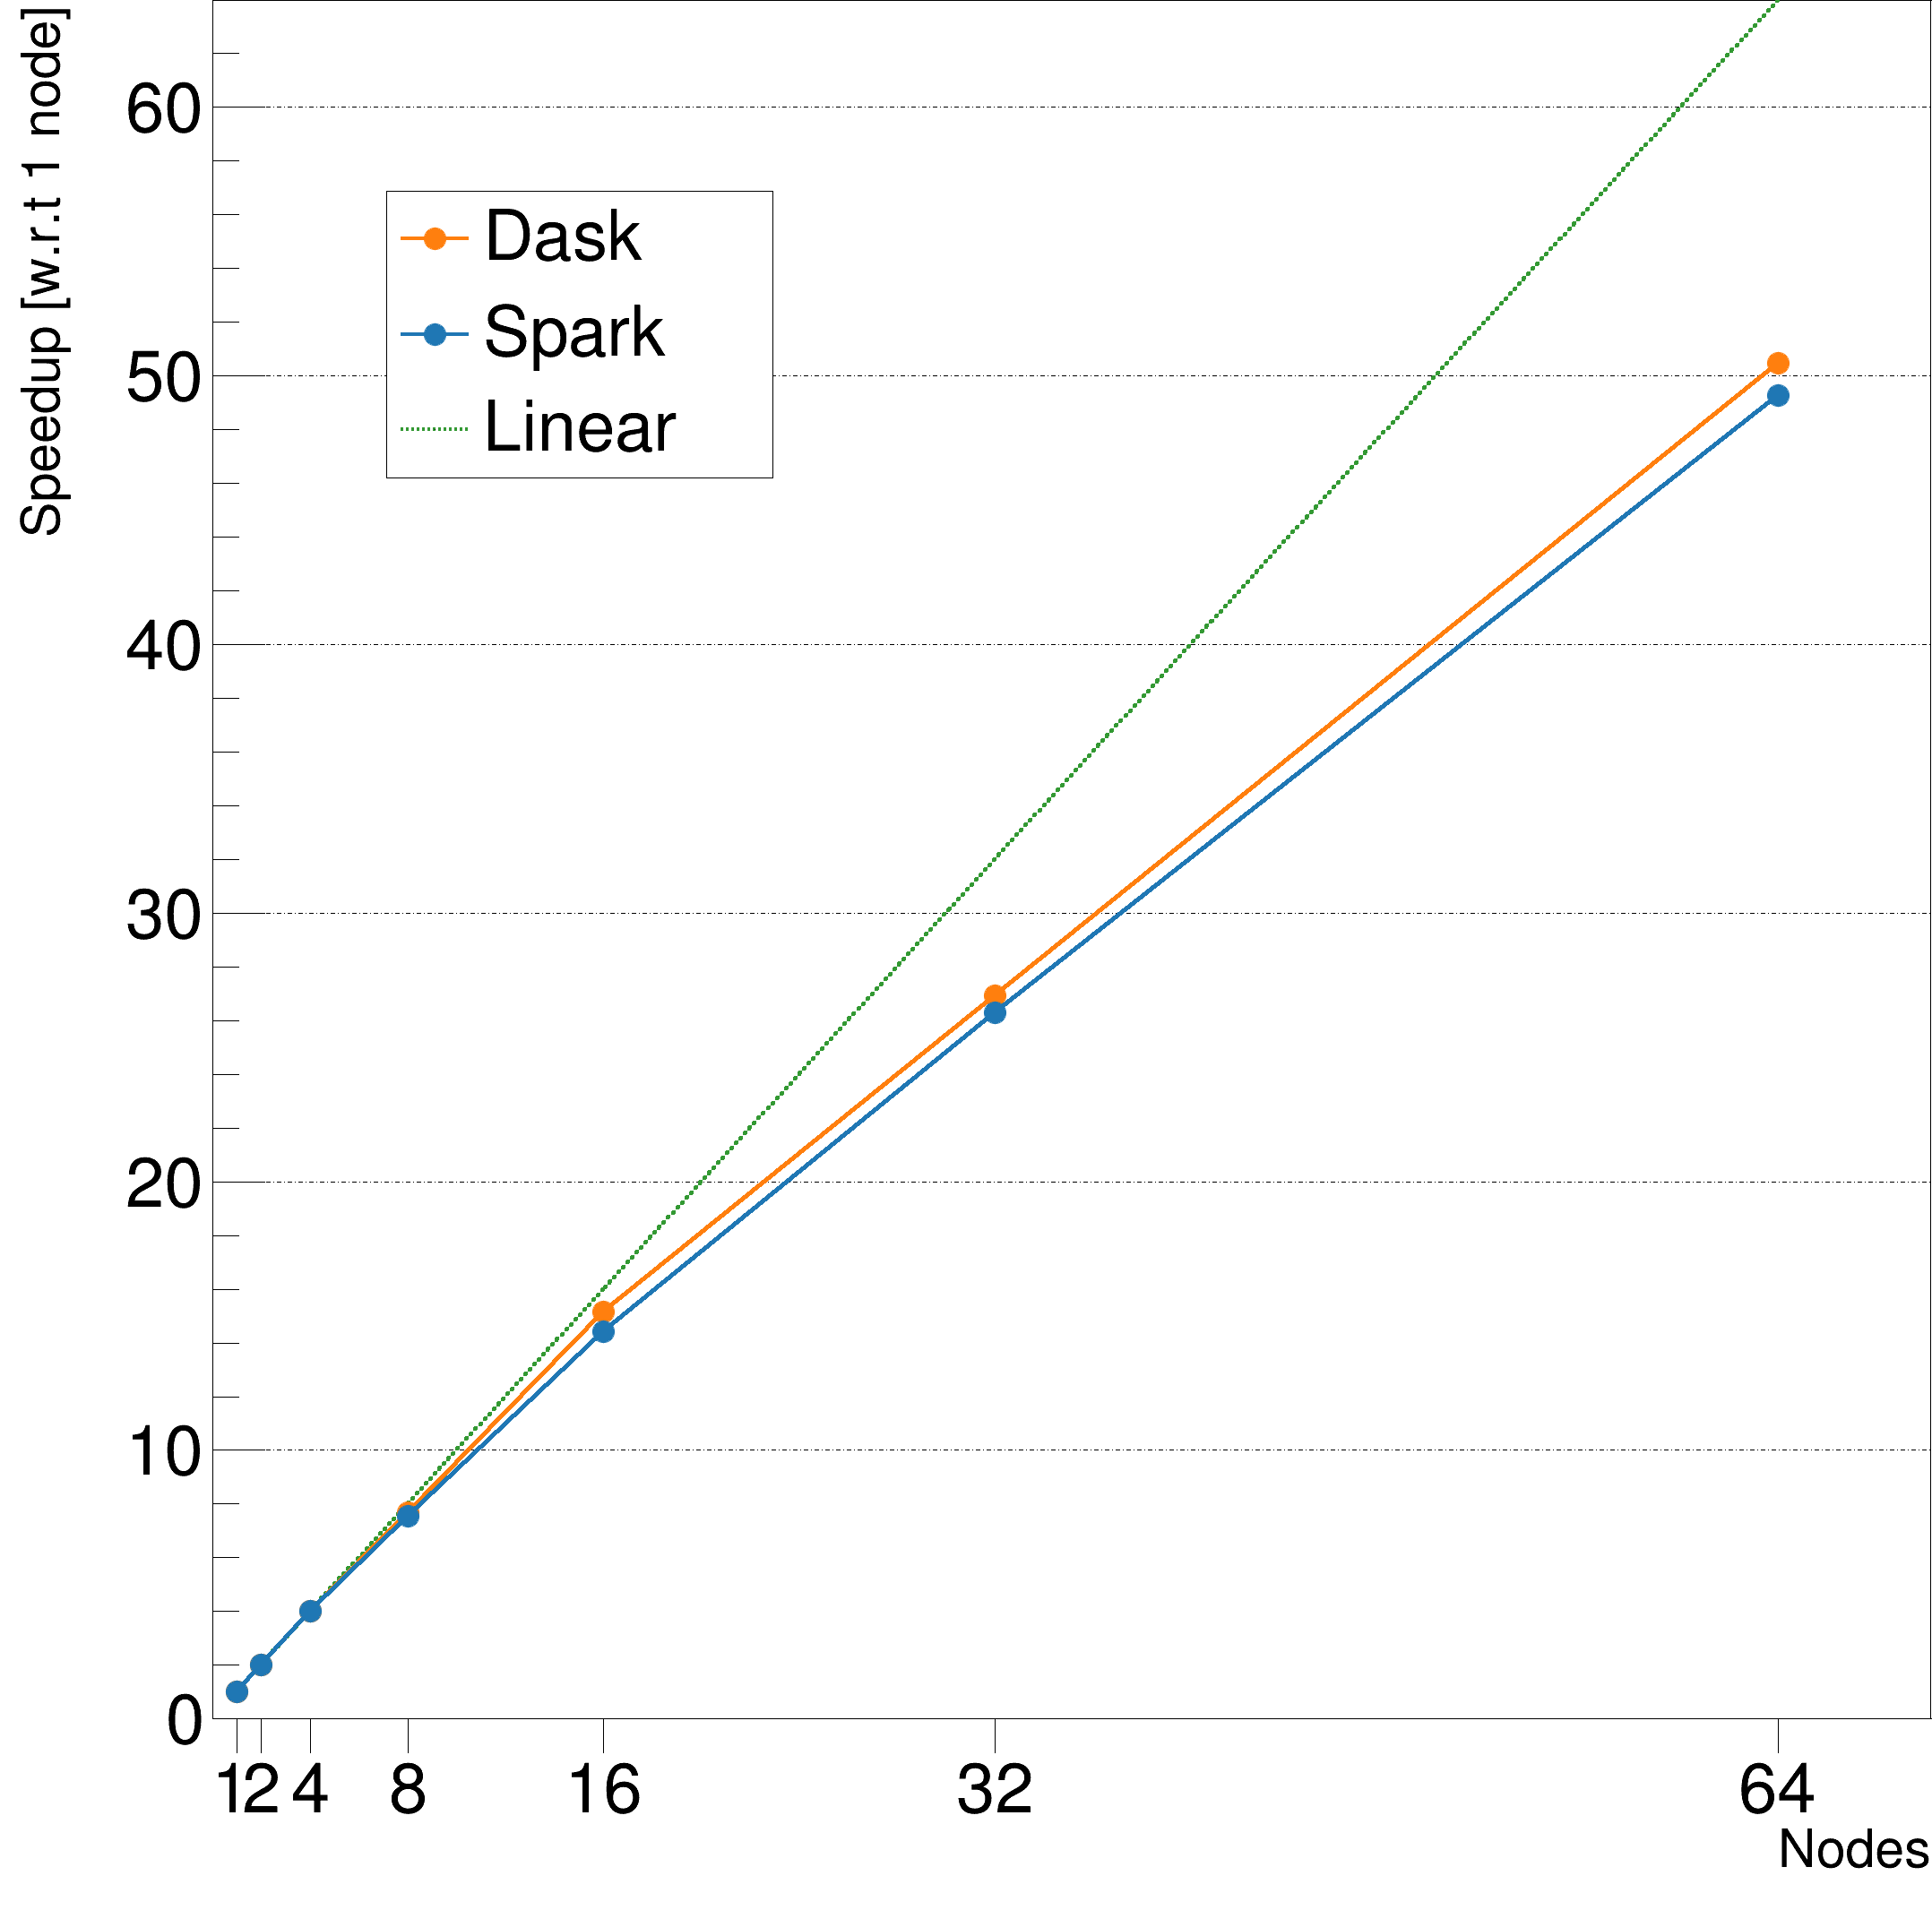

In [15]:
sparkgraph_cold = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                             numpy.array(dfs["spark"]["ncores"], dtype=float),
                             numpy.array(dfs["spark"]["speedup_cold"], dtype=float))
daskgraph_cold = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                            numpy.array(dfs["dask"]["ncores"], dtype=float),
                            numpy.array(dfs["dask"]["speedup_cold"], dtype=float))

idealspeedupgraph = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                                numpy.array(dfs["dask"]["ncores"], dtype=float),
                                numpy.array(dfs["dask"]["ncores"]/32, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_cold)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 node]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

#idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
#idealspeedupgraph.SetMarkerSize(1)
#idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")



dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -3.5, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)


daskgraph_cold.GetYaxis().SetLabelSize(0)
daskgraph_cold.SetMarkerSize(3)
daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kSolid)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(4)

daskgraph_cold.Draw("SAME PL")

sparkgraph_cold.GetYaxis().SetLabelSize(0)
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)

sparkgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_cold, "Dask")
legend.AddEntry(sparkgraph_cold, "Spark")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("speedup_cold.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file speedup_hot.png has been created


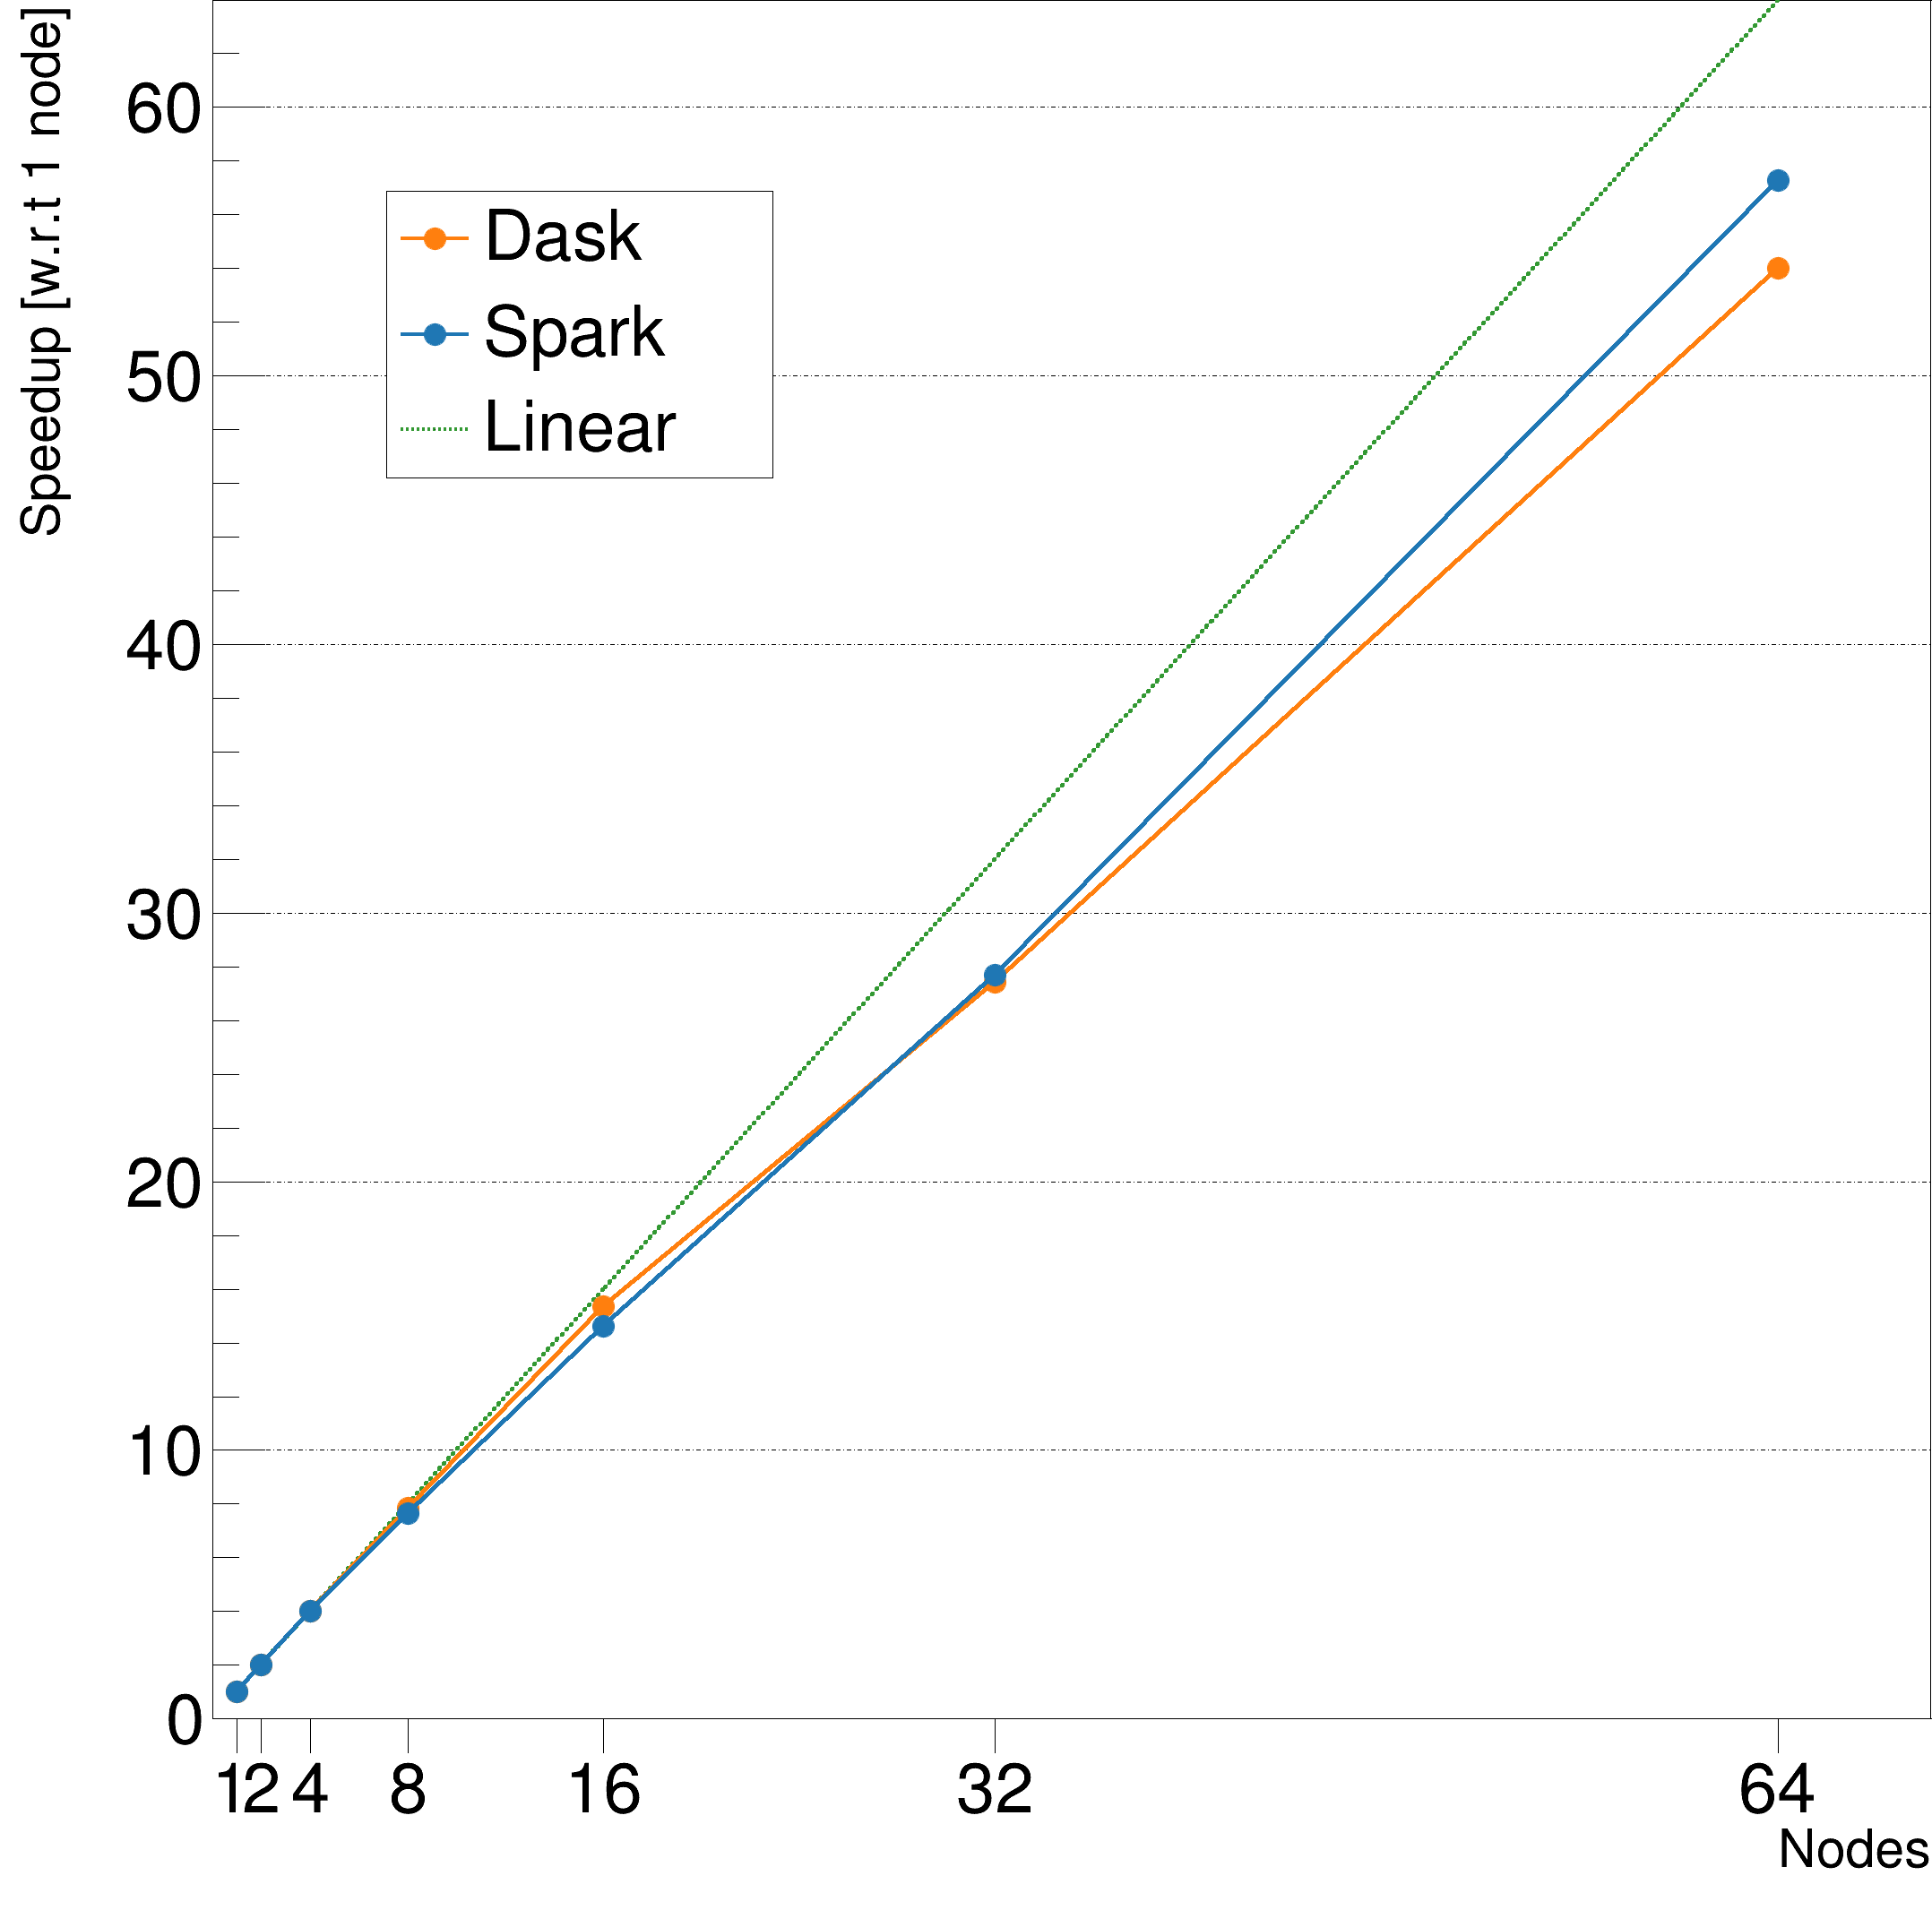

In [16]:
sparkgraph_hot = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                             numpy.array(dfs["spark"]["ncores"], dtype=float),
                             numpy.array(dfs["spark"]["speedup_hot"], dtype=float))
daskgraph_hot = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                            numpy.array(dfs["dask"]["ncores"], dtype=float),
                            numpy.array(dfs["dask"]["speedup_hot"], dtype=float))

idealspeedupgraph = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                                numpy.array(dfs["dask"]["ncores"], dtype=float),
                                numpy.array(dfs["dask"]["ncores"]/32, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_hot)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 node]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

#idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
#idealspeedupgraph.SetMarkerSize(1)
#idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")



dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -3.5, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)


daskgraph_hot.GetYaxis().SetLabelSize(0)
daskgraph_hot.SetMarkerSize(3)
daskgraph_hot.SetMarkerStyle(20)
daskgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_hot.SetLineStyle(ROOT.kSolid)
daskgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_hot.SetLineWidth(4)

daskgraph_hot.Draw("SAME PL")

sparkgraph_hot.GetYaxis().SetLabelSize(0)
sparkgraph_hot.SetMarkerSize(3)
sparkgraph_hot.SetMarkerStyle(20)
sparkgraph_hot.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_hot.SetLineStyle(ROOT.kSolid)
sparkgraph_hot.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_hot.SetLineWidth(4)

sparkgraph_hot.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_hot, "Dask")
legend.AddEntry(sparkgraph_hot, "Spark")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("speedup_hot.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_cold.png has been created


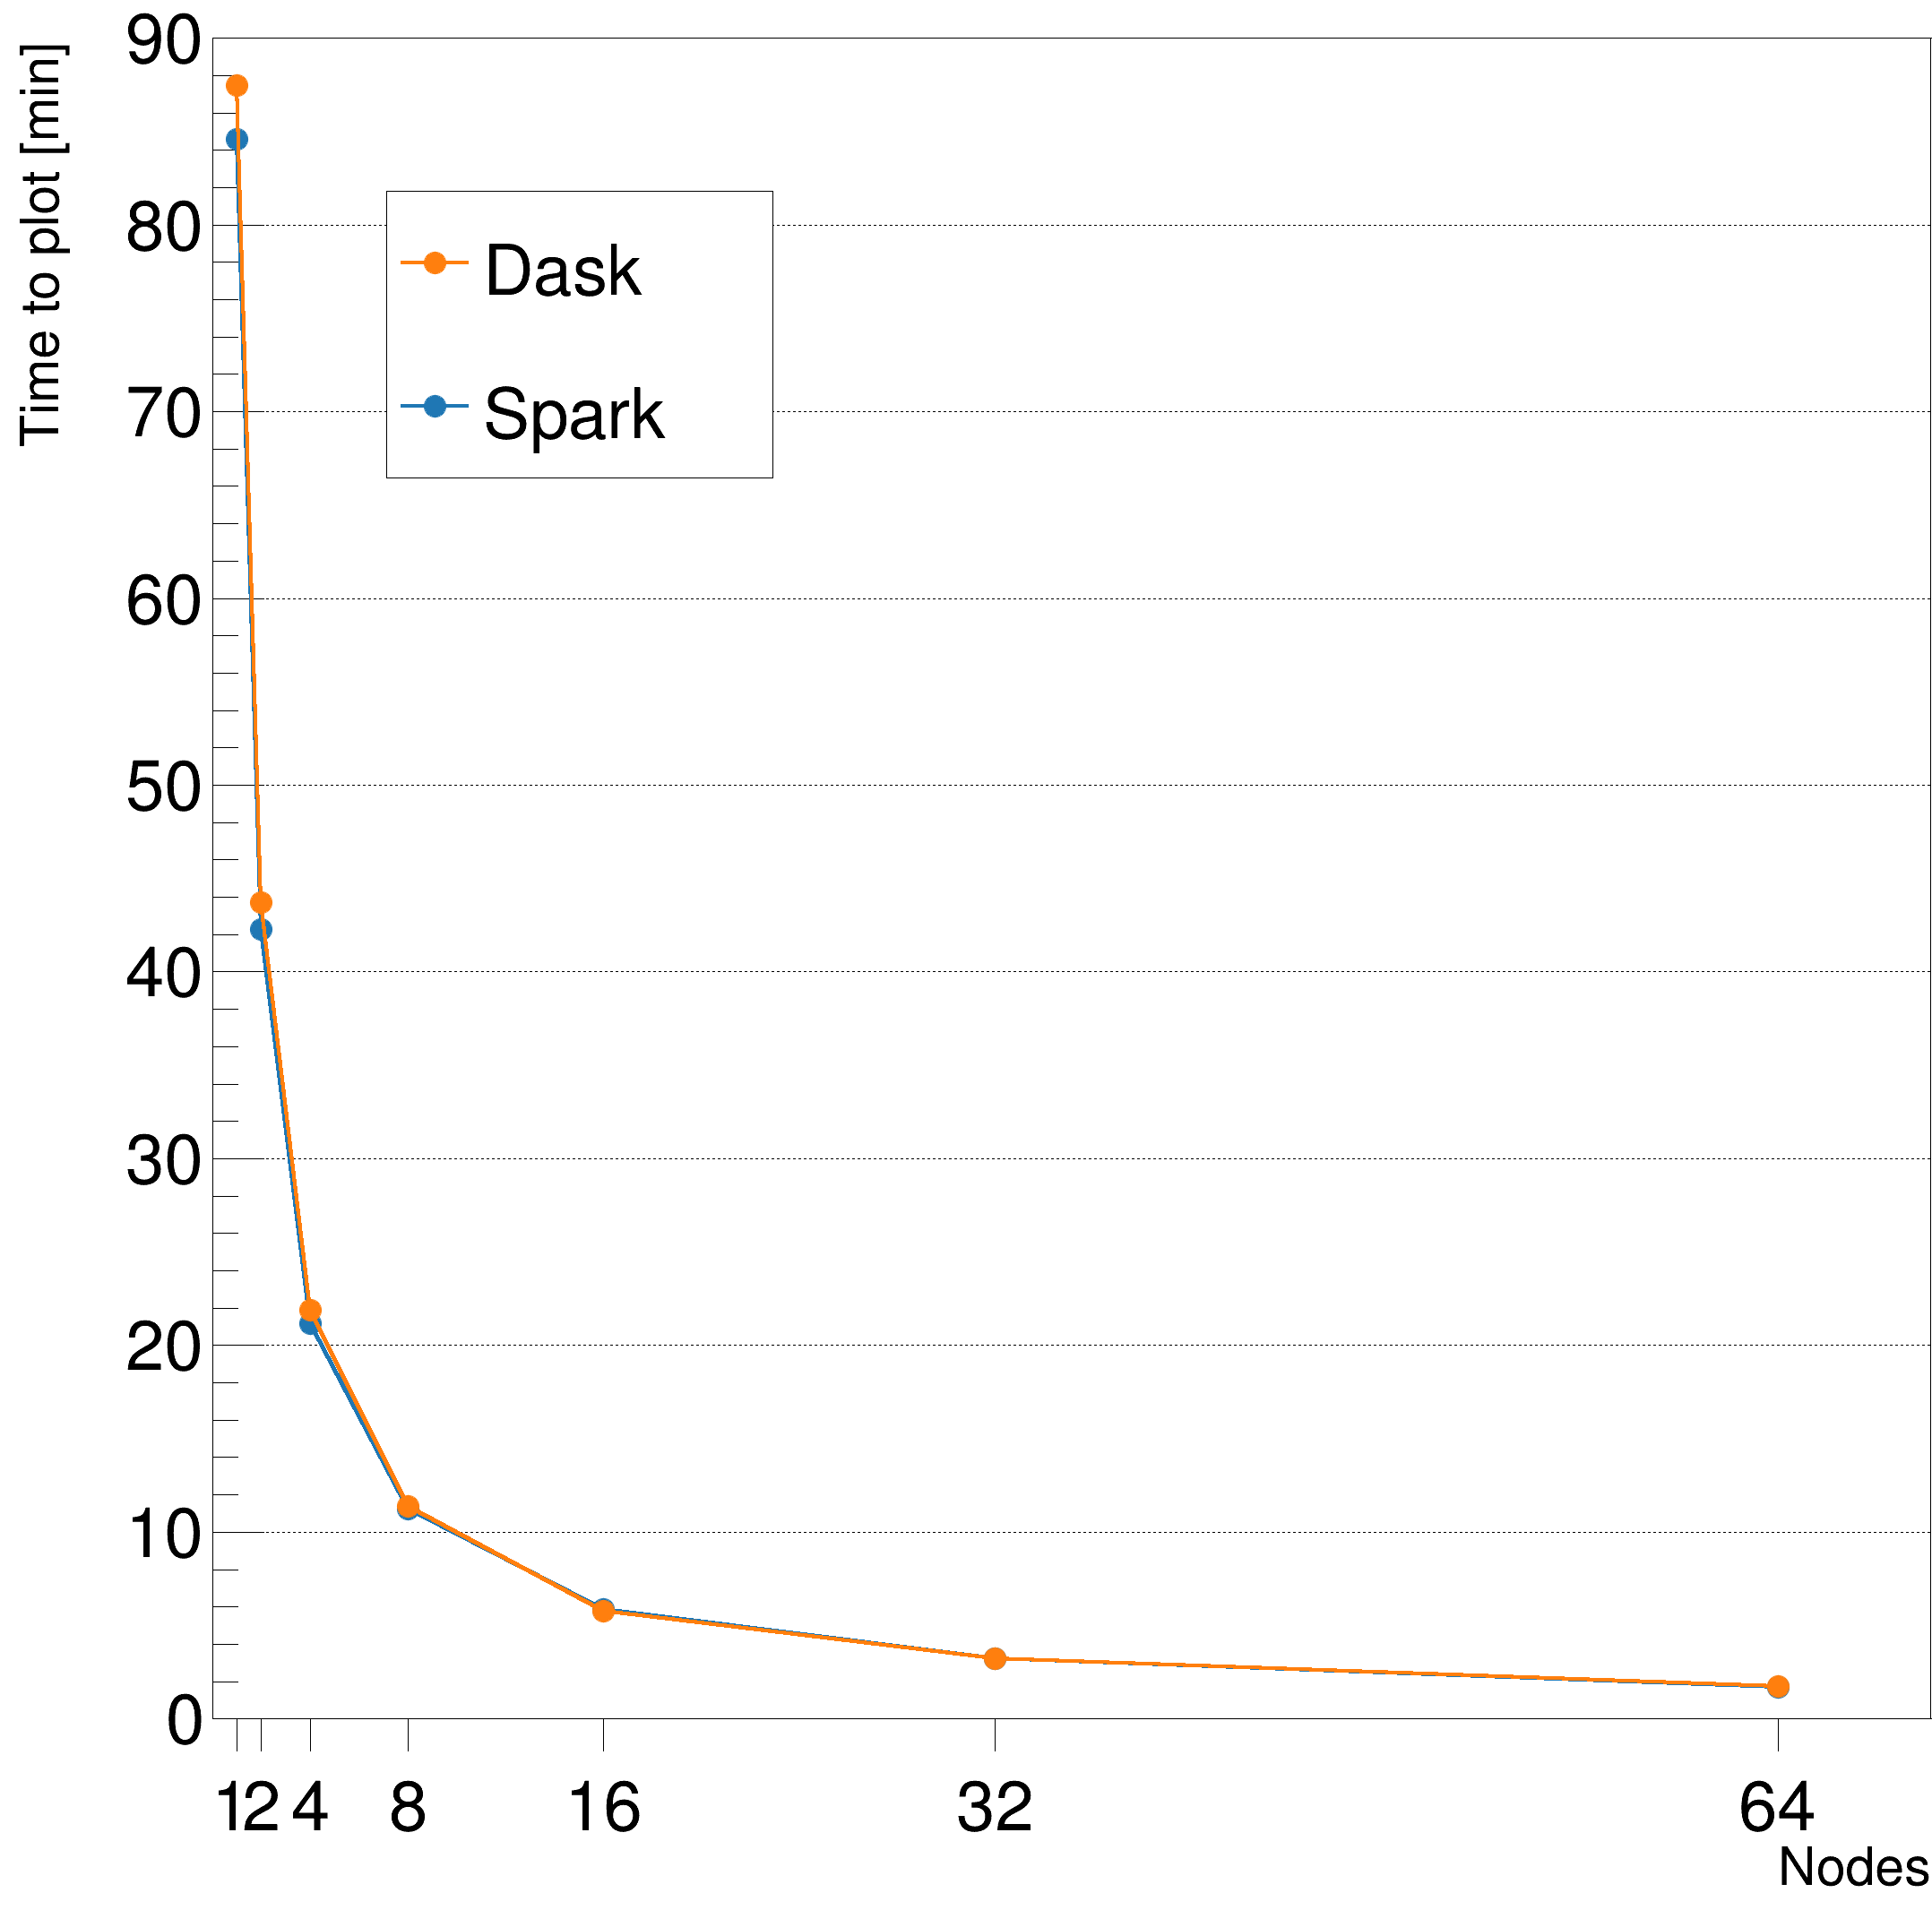

In [17]:
sparkgraph_cold = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                              numpy.array(dfs["spark"]["ncores"], dtype=float),
                              numpy.array(dfs["spark"]["cold_minutes"], dtype=float))
daskgraph_cold = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                             numpy.array(dfs["dask"]["ncores"], dtype=float),
                             numpy.array(dfs["dask"]["cold_minutes"], dtype=float))
width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)


ymin, ymax = get_y_min_max(sparkgraph_cold, daskgraph_cold)

sparkgraph_cold.SetTitle("")

sparkgraph_cold.GetXaxis().SetTitle("Nodes")
sparkgraph_cold.GetXaxis().SetTitleSize(0.03)
sparkgraph_cold.GetXaxis().SetTitleOffset(1.6)
sparkgraph_cold.GetXaxis().SetLabelSize(0)
sparkgraph_cold.GetXaxis().SetTickLength(0)

sparkgraph_cold.GetYaxis().SetTitle("Time to plot [min]")
sparkgraph_cold.GetYaxis().SetTitleSize(0.03)
sparkgraph_cold.GetYaxis().SetTitleOffset(1.8)
sparkgraph_cold.GetYaxis().SetRangeUser(0, round_to_nearest_5(ymax))
sparkgraph_cold.GetYaxis().SetLabelSize(0.04)
sparkgraph_cold.GetYaxis().SetNdivisions(510)
#sparkgraph.GetYaxis().SetTickLength(0)


sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)
sparkgraph_cold.Draw("ALP")


dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_cold.GetPointX(i)
    y = sparkgraph_cold.GetPointY(i)

    xt = ROOT.TLatex(x, -6, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_cold.GetYaxis().SetLabelSize(0)
daskgraph_cold.SetMarkerSize(3)
daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kSolid)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(4)

daskgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_cold, "Dask")
legend.AddEntry(sparkgraph_cold, "Spark")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(2)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("runtime_cold.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_hot.png has been created


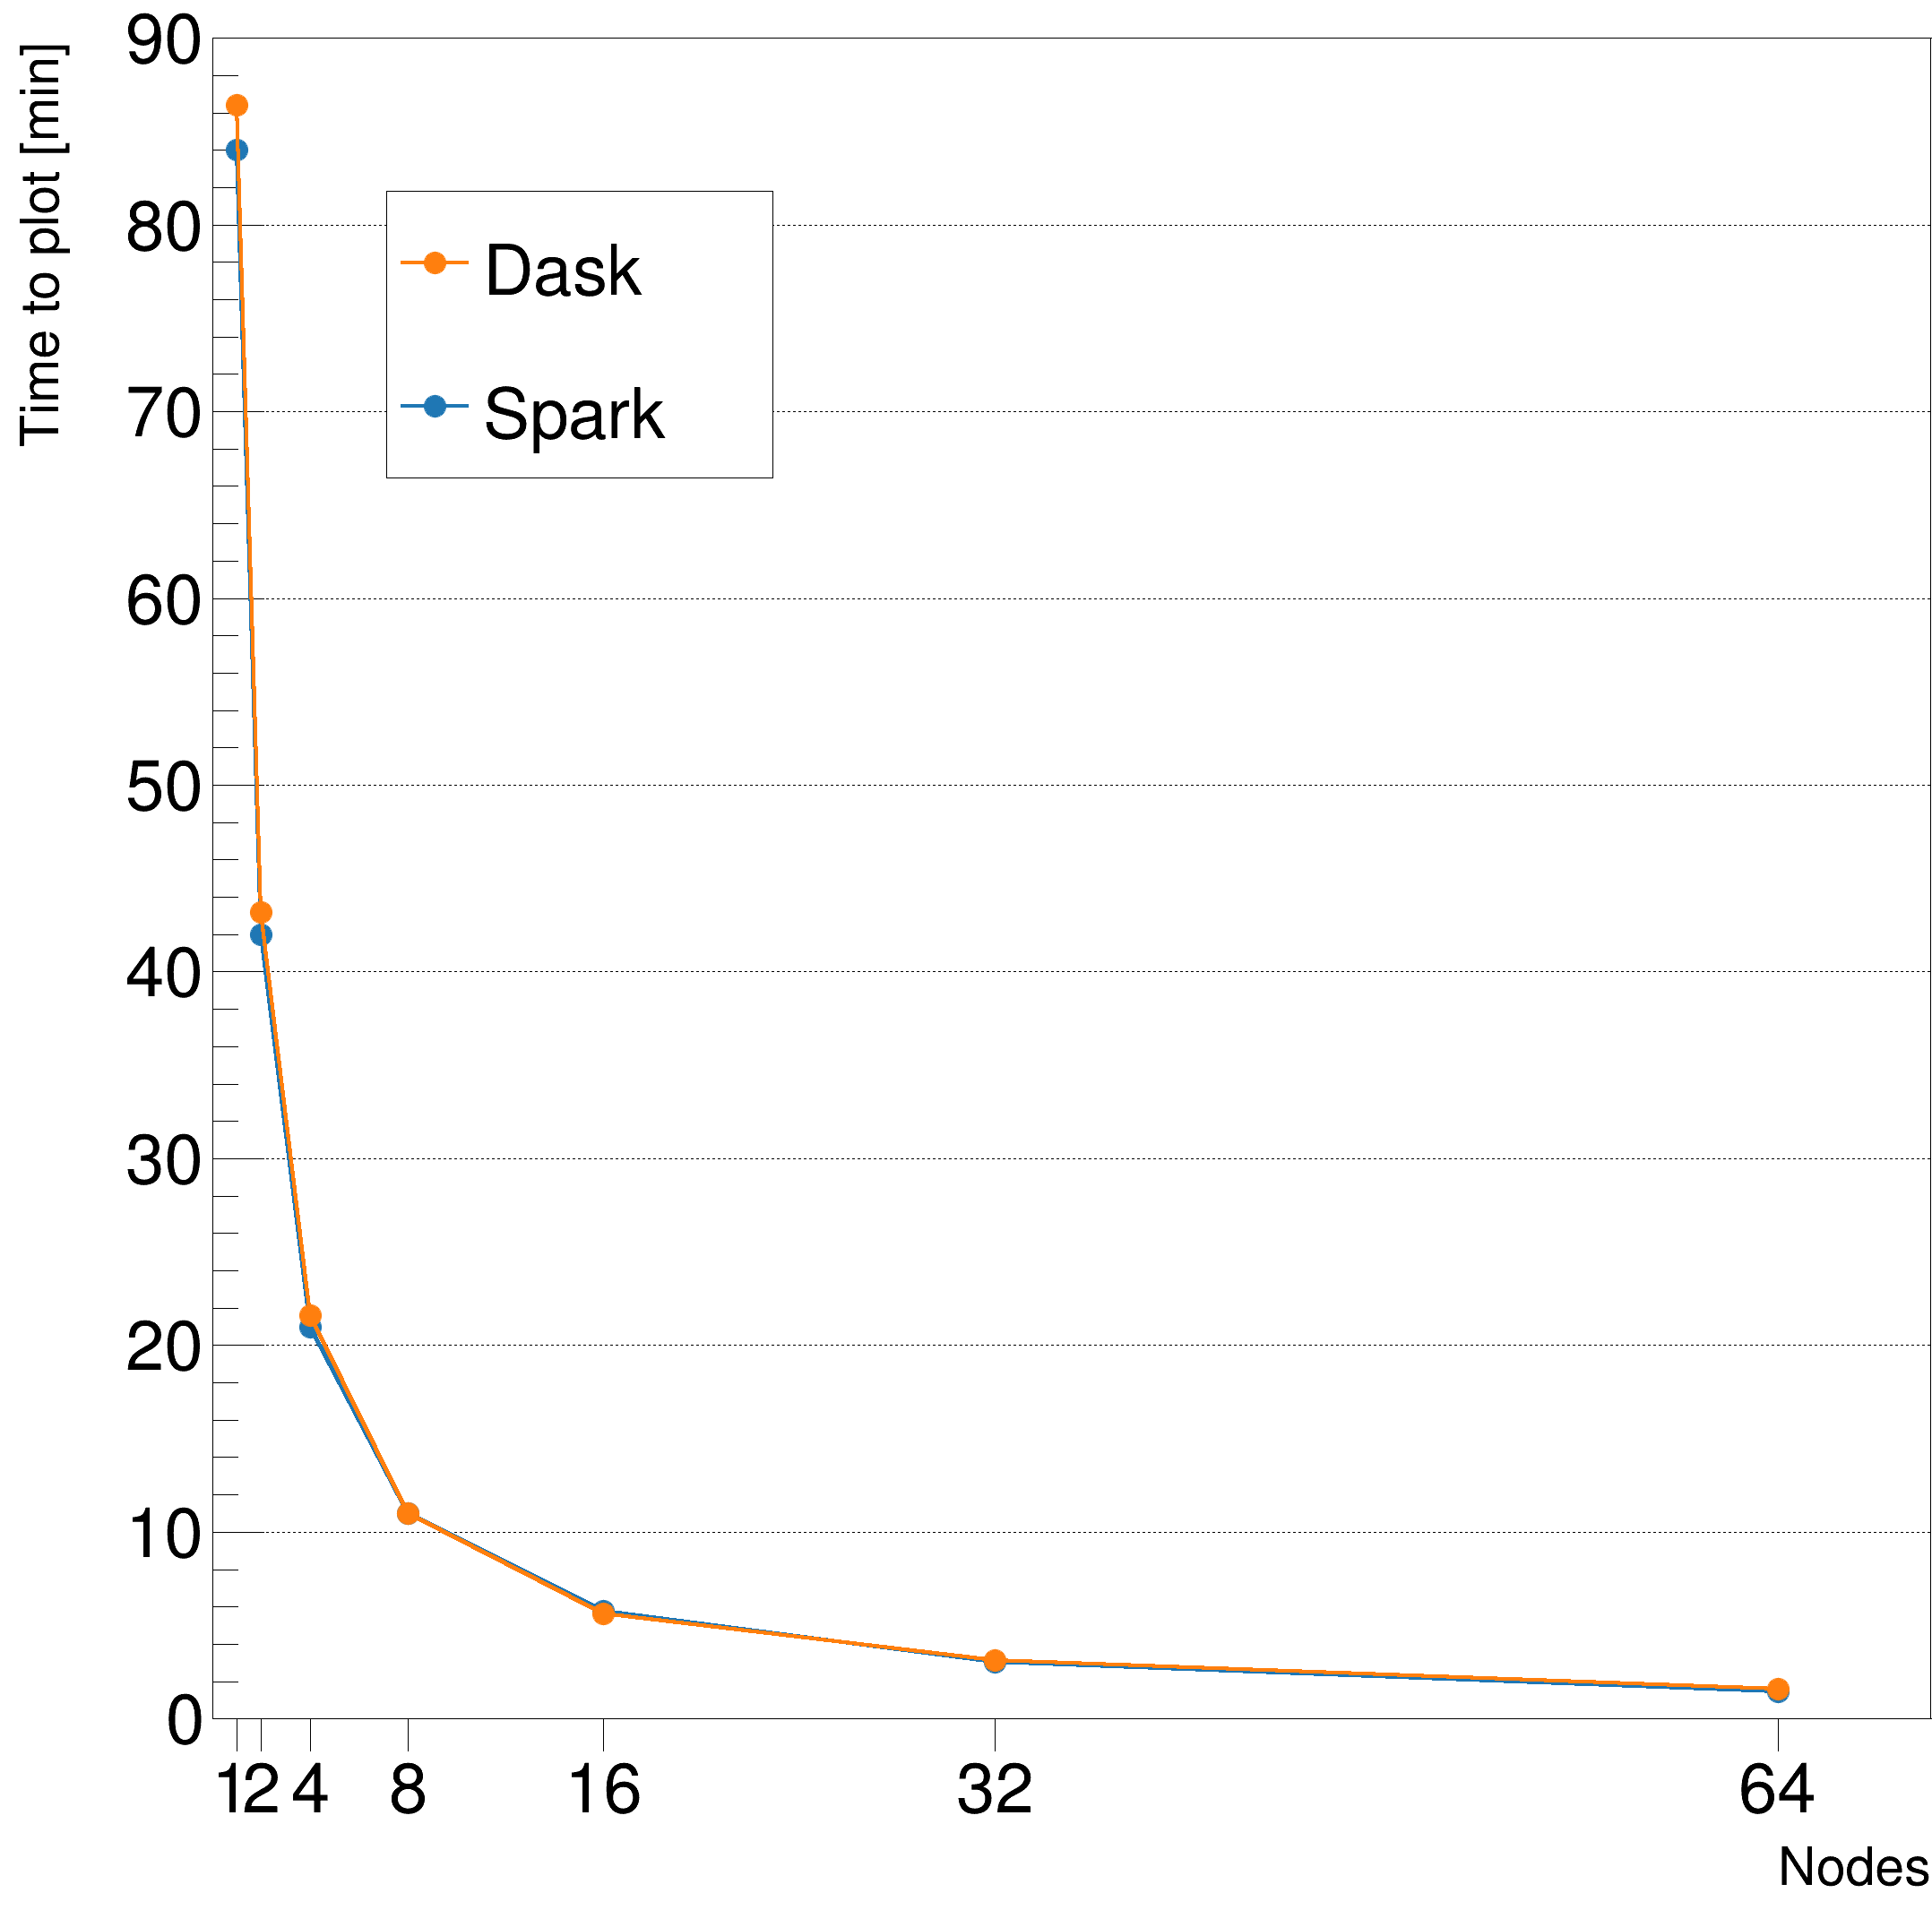

In [18]:
sparkgraph_cold = ROOT.TGraph(len(dfs["spark"]["ncores"]),
                              numpy.array(dfs["spark"]["ncores"], dtype=float),
                              numpy.array(dfs["spark"]["hot_minutes"], dtype=float))
daskgraph_cold = ROOT.TGraph(len(dfs["dask"]["ncores"]),
                             numpy.array(dfs["dask"]["ncores"], dtype=float),
                             numpy.array(dfs["dask"]["hot_minutes"], dtype=float))
width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)




ymin, ymax = get_y_min_max(sparkgraph_cold, daskgraph_cold)

sparkgraph_cold.SetTitle("")

sparkgraph_cold.GetXaxis().SetTitle("Nodes")
sparkgraph_cold.GetXaxis().SetTitleSize(0.03)
sparkgraph_cold.GetXaxis().SetTitleOffset(1.6)
sparkgraph_cold.GetXaxis().SetLabelSize(0)
sparkgraph_cold.GetXaxis().SetTickLength(0)

sparkgraph_cold.GetYaxis().SetTitle("Time to plot [min]")
sparkgraph_cold.GetYaxis().SetTitleSize(0.03)
sparkgraph_cold.GetYaxis().SetTitleOffset(1.8)
sparkgraph_cold.GetYaxis().SetRangeUser(0, round_to_nearest_5(ymax))
sparkgraph_cold.GetYaxis().SetLabelSize(0.04)
sparkgraph_cold.GetYaxis().SetNdivisions(510)
#sparkgraph.GetYaxis().SetTickLength(0)


sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)
sparkgraph_cold.Draw("ALP")


dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs["spark"]["ncores"])):
    x = sparkgraph_cold.GetPointX(i)
    y = sparkgraph_cold.GetPointY(i)

    xt = ROOT.TLatex(x, -5, str(int(x/32)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)


daskgraph_cold.GetYaxis().SetLabelSize(0)
daskgraph_cold.SetMarkerSize(3)
daskgraph_cold.SetMarkerStyle(20)
daskgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
daskgraph_cold.SetLineStyle(ROOT.kSolid)
daskgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
daskgraph_cold.SetLineWidth(4)

daskgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(daskgraph_cold, "Dask")
legend.AddEntry(sparkgraph_cold, "Spark")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(2)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("runtime_hot.png")